# Data Visualization Project
## Maximizing Marketing Profits: Predictive Modeling and Customer Segmentation for Campaign Success
### By Sacha Hangimana, Viola Brevi, Benie Nezerwa
# PART 1
## Analyze the data and provide insights with key descriptive statistics 
# Import libraries

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.stats import zscore

# Self-Organizing Maps
from minisom import MiniSom

# Scikit-learn: preprocessing, clustering, decomposition, and evaluation
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import (
    roc_curve, 
    auc, 
    classification_report, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# XGBoost classifier
from xgboost import XGBClassifier

# Imbalanced learning
from imblearn.over_sampling import SMOTE

In [2]:
df = pd.read_csv('marketing_campaign.csv', sep=';')
df.head()

ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524.0      1957.0  Graduation         Single  58138.0      0.0       0.0   
1  2174.0      1954.0  Graduation         Single  46344.0      1.0       1.0   
2  4141.0      1965.0  Graduation       Together  71613.0      0.0       0.0   
3  6182.0      1984.0  Graduation       Together  26646.0      1.0       0.0   
4  5324.0      1981.0         PhD        Married  58293.0      1.0       0.0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  2012-09-04     58.0     635.0  ...                7.0           0.0   
1  2014-03-08     38.0      11.0  ...                5.0           0.0   
2  2013-08-21     26.0     426.0  ...                4.0           0.0   
3  2014-02-10     26.0      11.0  ...                6.0           0.0   
4  2014-01-19     94.0     173.0  ...                5.0           0.0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0           0.0           0.0           0.0           0.0       0.0   
1           0.0           0.0           0.0           0.0       0.0   
2           0.0           0.0           0.0           0.0       0.0   
3           0.0           0.0           0.0           0.0       0.0   
4           0.0           0.0           0.0           0.0       0.0   

   Z_CostContact  Z_Revenue  Response  
0            3.0       11.0         1  
1            3.0       11.0         0  
2            3.0       11.0         0  
3            3.0       11.0         0  
4            3.0       11.0         0  

[5 rows x 29 columns]

In [3]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response'],
      dtype='object')

In [4]:
df.shape

(2241, 29)

# Data exploration

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2241 entries, 0 to 2240
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   float64
 1   Year_Birth           2240 non-null   float64
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   float64
 6   Teenhome             2240 non-null   float64
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   float64
 9   MntWines             2240 non-null   float64
 10  MntFruits            2240 non-null   float64
 11  MntMeatProducts      2240 non-null   float64
 12  MntFishProducts      2240 non-null   float64
 13  MntSweetProducts     2240 non-null   float64
 14  MntGoldProds         2240 non-null   float64
 15  NumDealsPurchases    2240 non-null   f

In [6]:
df.isnull().sum()

ID                      1
Year_Birth              1
Education               1
Marital_Status          1
Income                 25
Kidhome                 1
Teenhome                1
Dt_Customer             1
Recency                 1
MntWines                1
MntFruits               1
MntMeatProducts         1
MntFishProducts         1
MntSweetProducts        1
MntGoldProds            1
NumDealsPurchases       1
NumWebPurchases         1
NumCatalogPurchases     1
NumStorePurchases       1
NumWebVisitsMonth       1
AcceptedCmp3            1
AcceptedCmp4            1
AcceptedCmp5            1
AcceptedCmp1            1
AcceptedCmp2            1
Complain                1
Z_CostContact           1
Z_Revenue               1
Response                0
dtype: int64

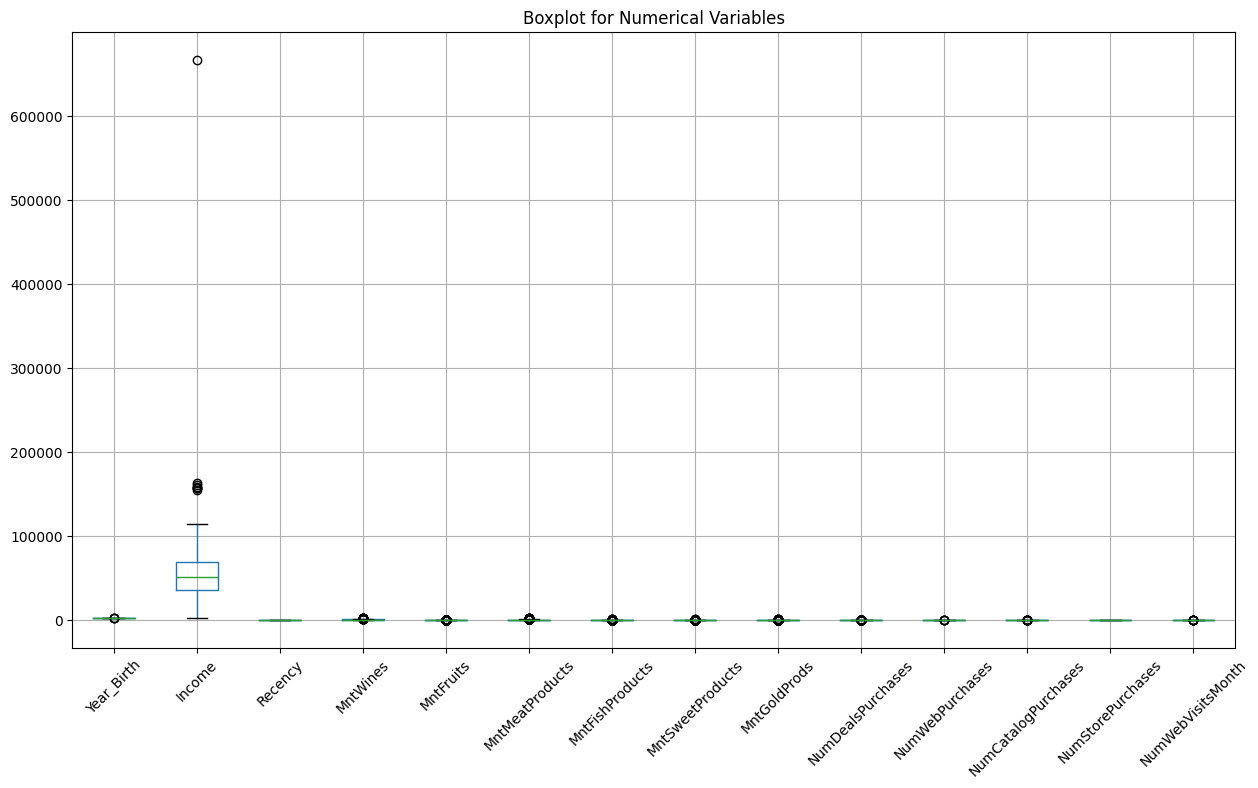

In [7]:
categorical_columns = [
        'Kidhome', 'Teenhome', 'AcceptedCmp1', 'AcceptedCmp2', 
        'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 
        'Education', 'Marital_Status']
exclude_columns = ['ID', 'Z_CostContact', 'Z_Revenue']
    
# Get numerical columns (excluding categorical and specified columns)
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = [col for col in numeric_columns 
                      if col not in categorical_columns + exclude_columns]
    
# Remove any duplicates
numeric_columns = list(dict.fromkeys(numeric_columns))
categorical_columns = list(dict.fromkeys(categorical_columns))


plt.figure(figsize=(15, 8))
df[numeric_columns].boxplot(rot=45)
plt.title("Boxplot for Numerical Variables")
plt.show()

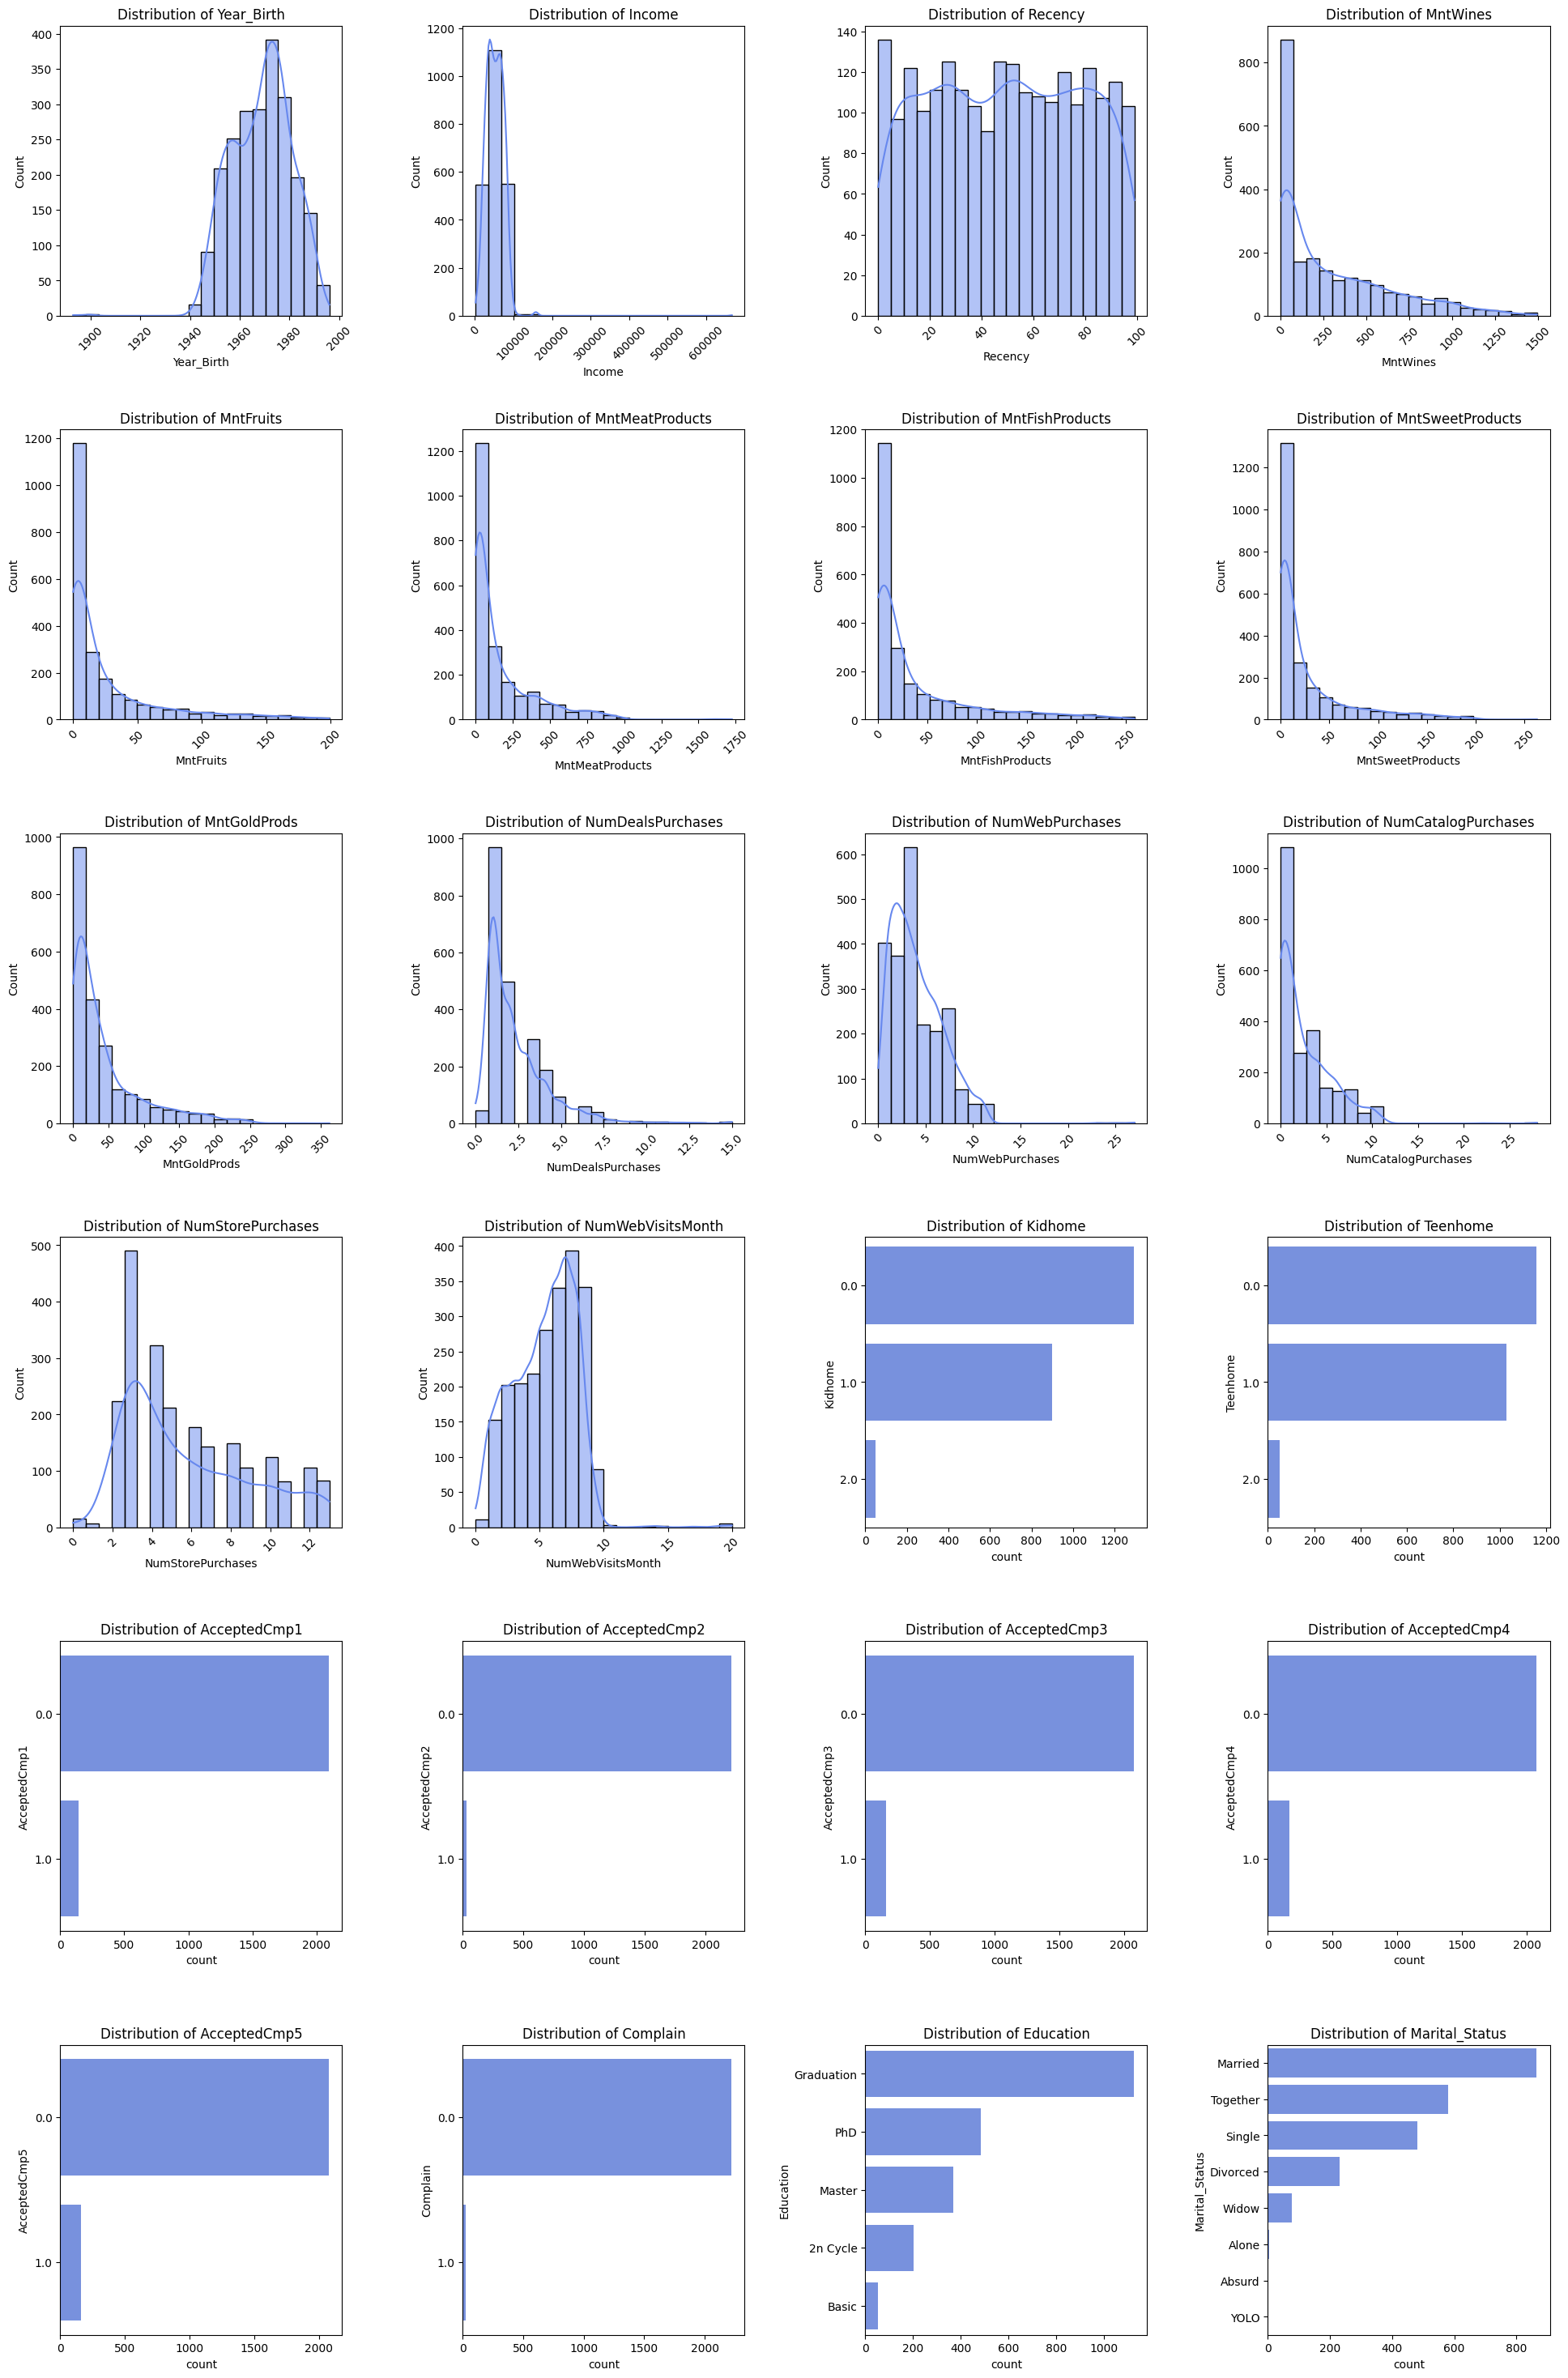

In [8]:
# Calculate layout
total_plots = len(numeric_columns) + len(categorical_columns)
cols = 4
rows = (total_plots // cols) + (total_plots % cols > 0)

# Create figure
plt.figure(figsize=(cols * 5, rows * 5))

# Define a consistent color palette
palette = sns.color_palette("coolwarm")

# Plot numerical distributions
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(rows, cols, i)
    sns.histplot(data=df, x=col, kde=True, bins=20, color=palette[0])  # Using the third color from the palette
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)

# Plot categorical distributions
for i, col in enumerate(categorical_columns, len(numeric_columns) + 1):
    plt.subplot(rows, cols, i)
    order = df[col].value_counts().index
    sns.countplot(data=df, y=col, order=order, color=palette[0])  # Apply the full palette for categorical plots
    plt.title(f'Distribution of {col}')

# Adjust layout
plt.tight_layout(pad=3.0)
plt.show()

In [9]:
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Define outlier criteria
outliers = ((df[numeric_columns] < (Q1 - 1.5 * IQR)) | (df[numeric_columns] > (Q3 + 1.5 * IQR)))

# Display outlier summary
outlier_counts = outliers.sum()
print("Number of outliers per column:")
print(outlier_counts[outlier_counts > 0])

Number of outliers per column:
Year_Birth               3
Income                   8
MntWines                35
MntFruits              227
MntMeatProducts        175
MntFishProducts        223
MntSweetProducts       248
MntGoldProds           207
NumDealsPurchases       86
NumWebPurchases          4
NumCatalogPurchases     23
NumWebVisitsMonth        8
dtype: int64


In [10]:
# Compute IQR for Income
Q1 = df['Income'].quantile(0.25)
Q3 = df['Income'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['Income'] >= lower_bound) & (df['Income'] <= upper_bound)]

# Compute IQR for Income
Q1 = df['Year_Birth'].quantile(0.25)
Q3 = df['Year_Birth'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
df = df[(df['Year_Birth'] >= lower_bound) & (df['Year_Birth'] <= upper_bound)]

# Check new shape
print(f"New dataset shape after outlier removal: {df.shape}")

New dataset shape after outlier removal: (2205, 29)


In [11]:
# Convert 'Dt_Customer' in datetime format
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%Y-%m-%d')

# Create new features
df['Age'] = 2025 - df['Year_Birth']
df['Customer_Since'] = (pd.to_datetime('today') - df['Dt_Customer']).dt.days
df['Total_Children'] = df['Kidhome'] + df['Teenhome']
df['Total_Spending'] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)
df['Online_Purchase_Ratio'] = df['NumWebPurchases'] / (df['NumWebPurchases'] + df['NumStorePurchases'] + df['NumCatalogPurchases'] + 1)
df['Total_Campaigns_Accepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum(axis=1)

# Group Marital Status
def clean_marital_status(status):
    if status in ['Single']:
        return 'Single'
    elif status in ['Together']:
        return 'In a Relationship'
    elif status in ['Married']:
        return 'Married'
    elif status in ['Divorced', 'Widow']:
        return 'Separated'
    else:
        return 'Other'  # Catch 'Alone', 'Absurd', 'YOLO'

df['Marital_Status_Grouped'] = df['Marital_Status'].apply(clean_marital_status)

# Group Education Status
def clean_education(level):
    if level == 'Basic':
        return 'Basic Education'
    elif level == '2n Cycle':
        return 'High School'
    elif level == 'Graduation':
        return 'Bachelor'
    elif level in ['Master', 'PhD']:
        return 'Postgraduate'
    else:
        return 'Other'

df['Education_Status_Grouped'] = df['Education'].apply(clean_education)

def categorize_web_visits(visits):
    if visits <= 4:
        return 'Low'
    elif visits <= 10:
        return 'Medium'
    else:
        return 'High'

df['Web_Visit_Category'] = df['NumWebVisitsMonth'].apply(categorize_web_visits)

numeric_columns.extend(['Total_Spending', 'Total_Children', 'Customer_Since', 'Age', 'Online_Purchase_Ratio', 'Total_Campaigns_Accepted'])

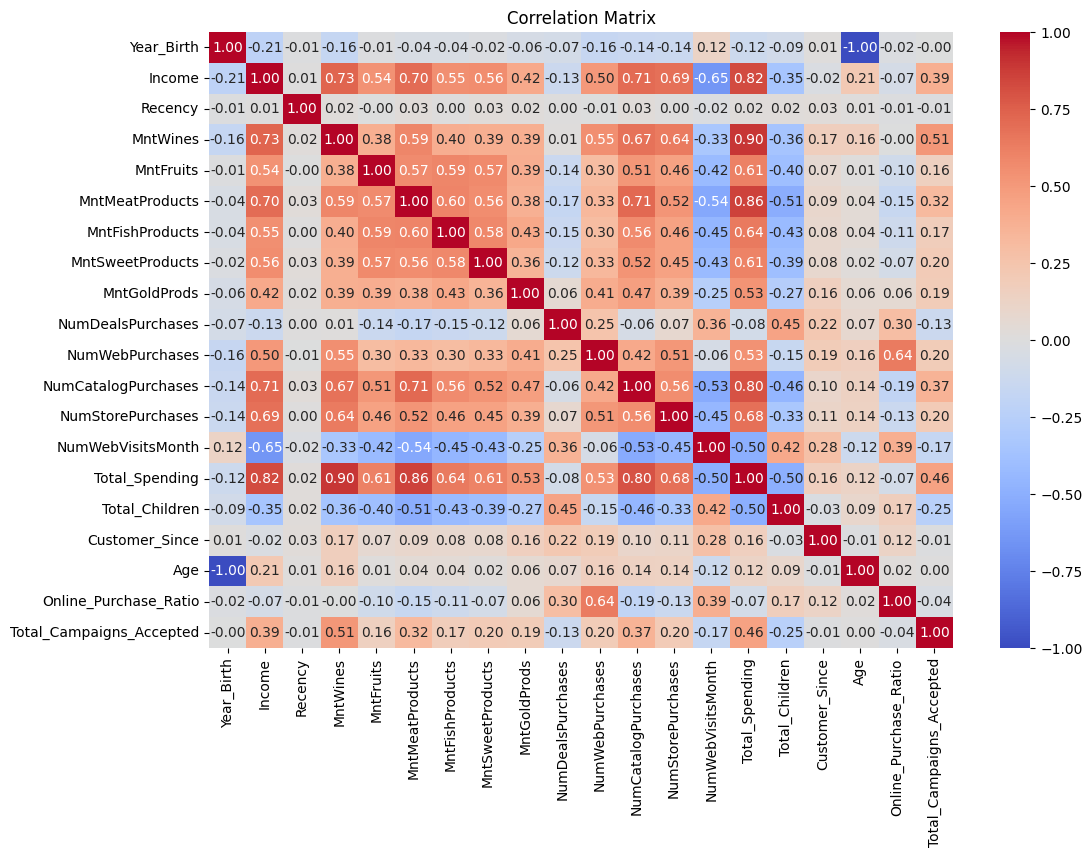

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

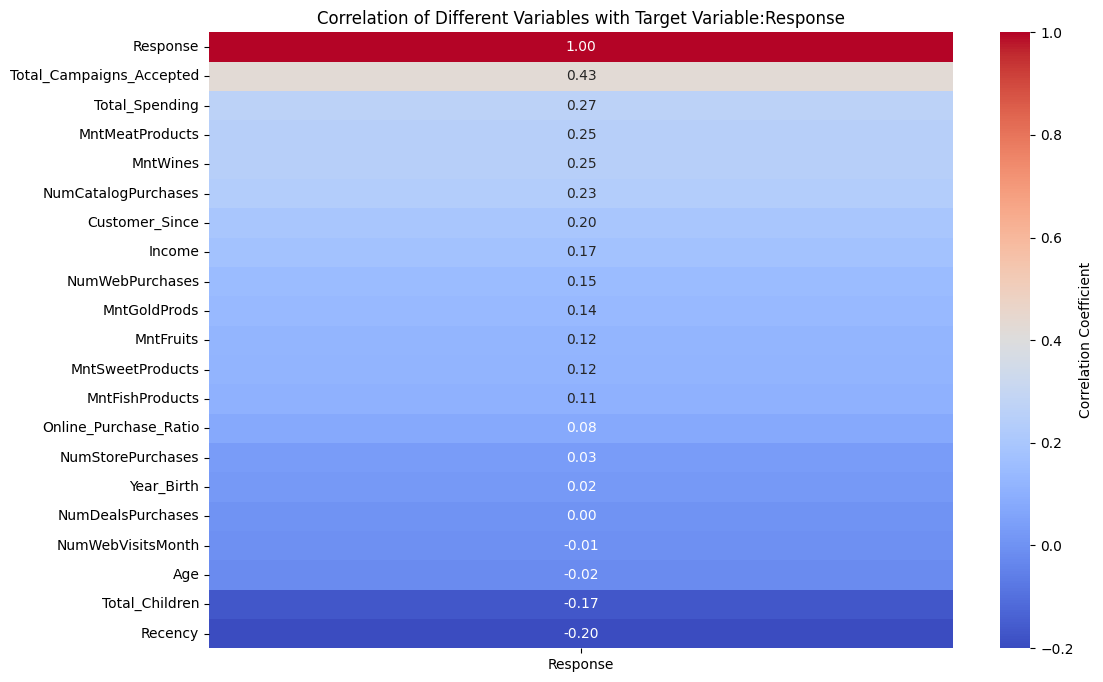

In [13]:
numeric_columns.append('Response')

# Plot the correlation heatmap focused on 'response' variable
plt.figure(figsize=(12, 8))
correlation_matrix = df[numeric_columns].corr()

# Extract correlations with the 'response' variable
response_corr = correlation_matrix['Response'].sort_values(ascending=False)

# Create a heatmap of the correlations with 'response'
sns.heatmap(response_corr.to_frame(), annot=True, cmap='coolwarm', fmt='.2f', cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation of Different Variables with Target Variable:Response')
plt.show()

The chart shows that the most correlated factor with response is the total number of accepted campaigns, followed by total spending and purchases of specific products such as meat and wine.  
On the other hand, variables like recency* and the total number of children have a negative correlation, suggesting that a longer gap since the last purchase and a higher number of children may reduce the likelihood of response.

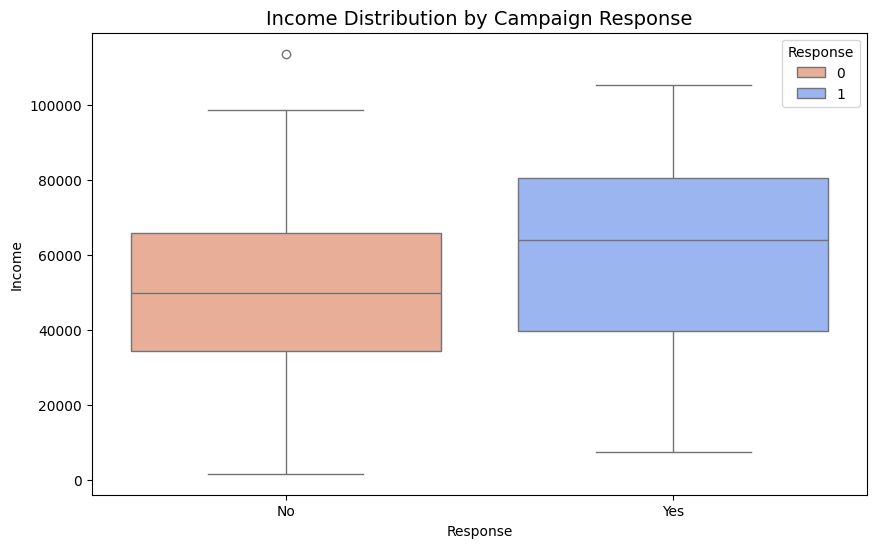

In [14]:
color1= (0.5543118699137254, 0.6900970112156862, 0.9955155482352941)
color2= (0.9673165156666667, 0.6574708288078431, 0.5381601507)

df['Response'] = df['Response'].astype(int)
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Response', y='Income', hue='Response', palette=[color2, color1])
plt.title("Income Distribution by Campaign Response", fontsize=14)
plt.xlabel("Response")
plt.ylabel("Income")
plt.xticks([0, 1], ['No', 'Yes'])
plt.show()

The box plot shows that customers with higher incomes are more likely to respond positively (1) to the campaign compared to those who did not (0). The median income is higher for responders, suggesting that wealthier individuals are more engaged. However, both groups have a similar income distribution, meaning income alone is not the only factor influencing responses.This insight suggests that while targeting high-income customers may improve campaign success, other factors like spending habits and engagement should also be considered.

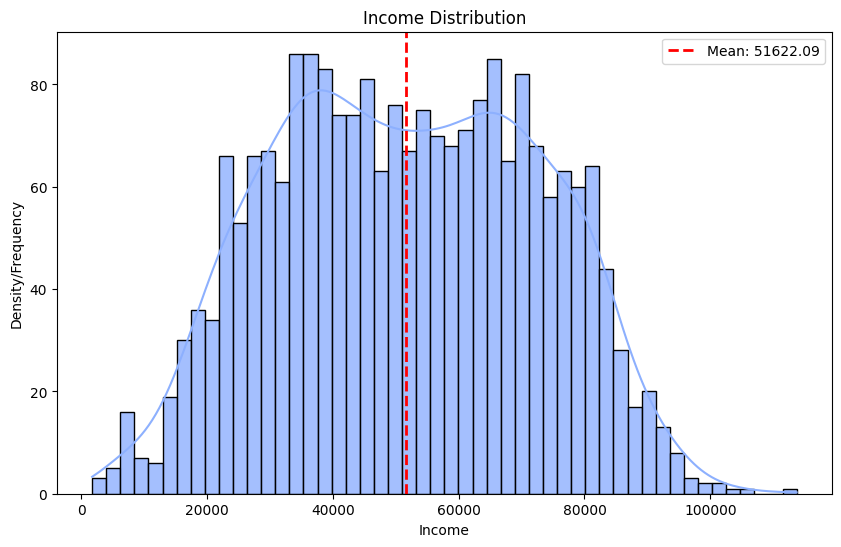

In [15]:
# Define color
couleur=(0.5543118699137254, 0.6900970112156862, 0.9955155482352941)

# Calculate mean
income_mean = np.mean(df['Income'])

# Plot histogram
plt.figure(figsize=(10, 6))
sns.histplot(df['Income'], bins=50, kde=True, color=couleur, edgecolor='black', alpha=0.8)

# Add a red line for the mean
plt.axvline(income_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {income_mean:.2f}')

# Labels and title
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Density/Frequency')
plt.legend()

# Show plot
plt.show()

Most customers earn between 30,000 MU and 70,000 MU, with peaks around 40,000 MU and 60,000 MU. The income distribution is slightly right-skewed, with a small group earning above 100,000 MU.  
This suggests a financially stable, middle-income majority, while the high-income segment offers opportunities for premium sales.

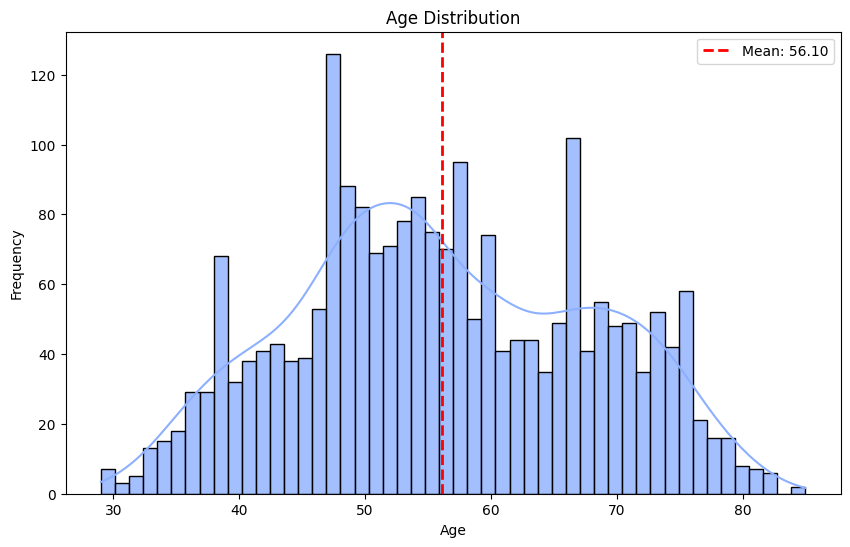

In [16]:
# Calculate mean
age_mean = np.mean(df['Age'])

# Create the plot
plt.figure(figsize=(10, 6))

# Use sns.histplot instead of plt.hist to support KDE
sns.histplot(df['Age'], bins=50, kde=True, color=couleur, edgecolor='black', alpha=0.8)

# Add a red line for the mean
plt.axvline(age_mean, color='red', linestyle='dashed', linewidth=2, label=f'Mean: {age_mean:.2f}')

# Labels and title
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend()

# Show plot
plt.show()

The majority of customers are aged between 40 and 70, with a peak at 50 years.  
This implies that marketing efforts should focus on the preferences of this age group, while exploring strategies to attract younger customers for long-term growth.

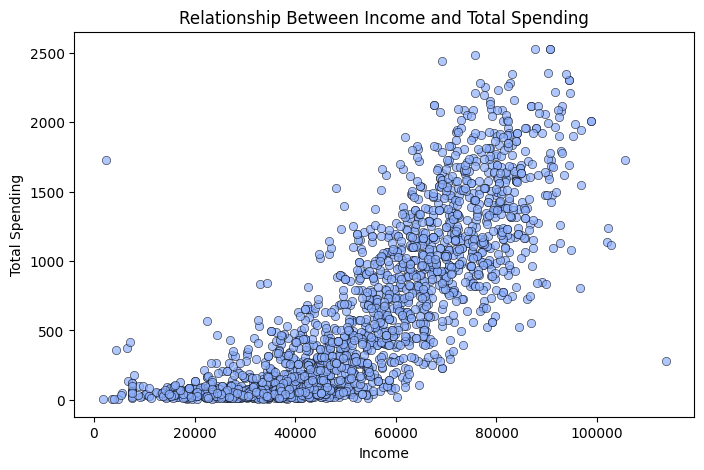

In [17]:
plt.figure(figsize=(8,5))
sns.scatterplot(x=df['Income'], y=df['Total_Spending'], alpha=0.7, color=couleur, edgecolor='black')
plt.title("Relationship Between Income and Total Spending")
plt.xlabel("Income")
plt.ylabel("Total Spending")
plt.show()

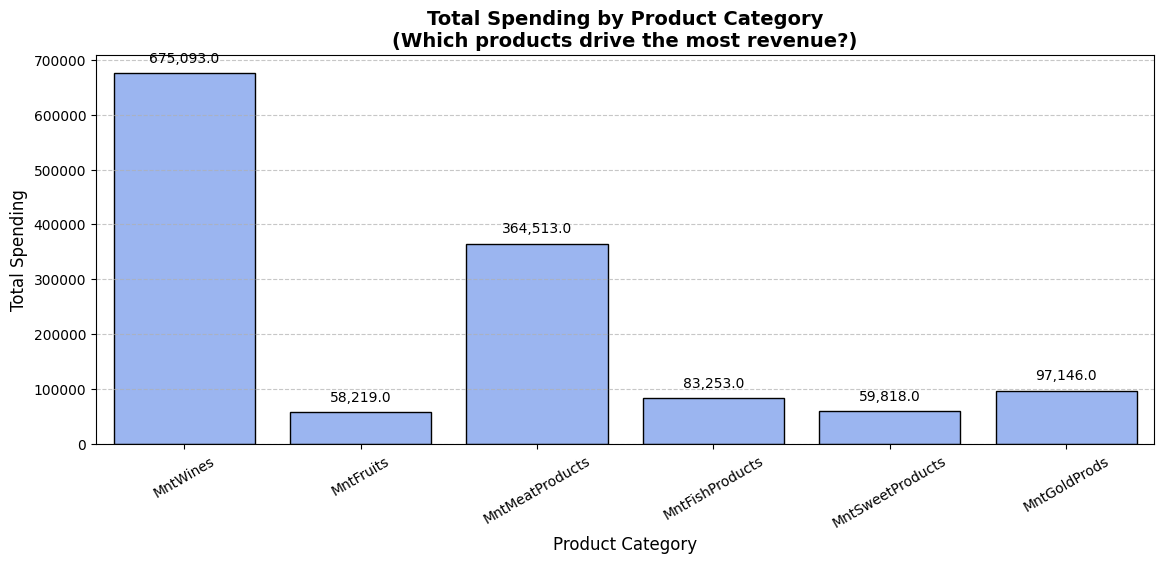

In [18]:
spending_columns = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
df_spending = df[spending_columns].sum()

plt.figure(figsize=(12, 6))
 # colors = sns.color_palette("Blues", len(df_spending))  # Gradient color
sns.barplot(x=df_spending.index, y=df_spending.values,color=couleur, edgecolor='black')

# Title & Labels
plt.title('Total Spending by Product Category\n(Which products drive the most revenue?)', fontsize=14, fontweight='bold')
plt.xlabel('Product Category', fontsize=12)
plt.ylabel('Total Spending', fontsize=12)
plt.xticks(fontsize=10, rotation=30)
plt.yticks(fontsize=10)

# Data Labels
for index, value in enumerate(df_spending.values):
    plt.text(index, value + 20000, f'{value:,}', ha='center', fontsize=10)

# Grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout(pad=2)
plt.show()

The figure shows that wine products are the most purchased, followed by meat products, with fruit products being the least popular. Now, let's see if this pattern changes when we analyze spending across different income levels.

C:\Users\user\AppData\Local\Temp\ipykernel_13260\524823032.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  product_spending_income = df.groupby(income_bins)[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].mean()


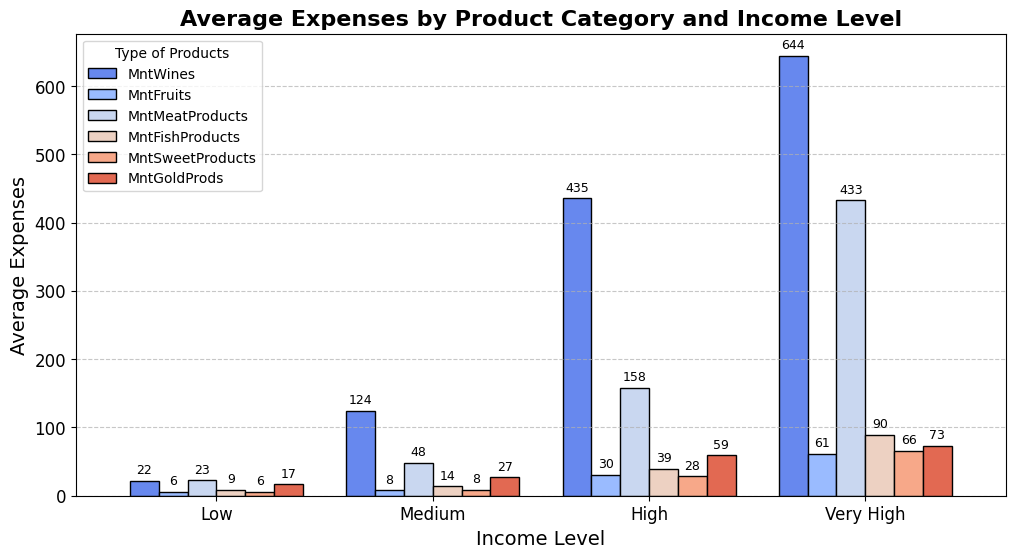

In [19]:
# Creating income bins
income_bins = pd.qcut(df['Income'], q=4, labels=["Low", "Medium", "High", "Very High"])

# Grouping by income levels and calculating mean spending per product category
product_spending_income = df.groupby(income_bins)[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].mean()

# Updated color palette for better contrast
palette_income = sns.color_palette("coolwarm", len(product_spending_income.columns))

# Plot
ax = product_spending_income.plot(kind="bar", figsize=(12, 6), color=palette_income, edgecolor="black", width=0.8)

# Improve title and labels
plt.title("Average Expenses by Product Category and Income Level", fontsize=16, fontweight='bold')
plt.xlabel("Income Level", fontsize=14)
plt.ylabel("Average Expenses", fontsize=14)
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)

# Add data labels
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=9, padding=3)

plt.legend(title="Type of Products", fontsize=10, loc="upper left", bbox_to_anchor=(0, 1))

# Add a grid for better readability
ax.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()

Across income levels, wines are the most purchased product, followed by meat.This trend is especially noticeable among Medium, High and Very High income earners.

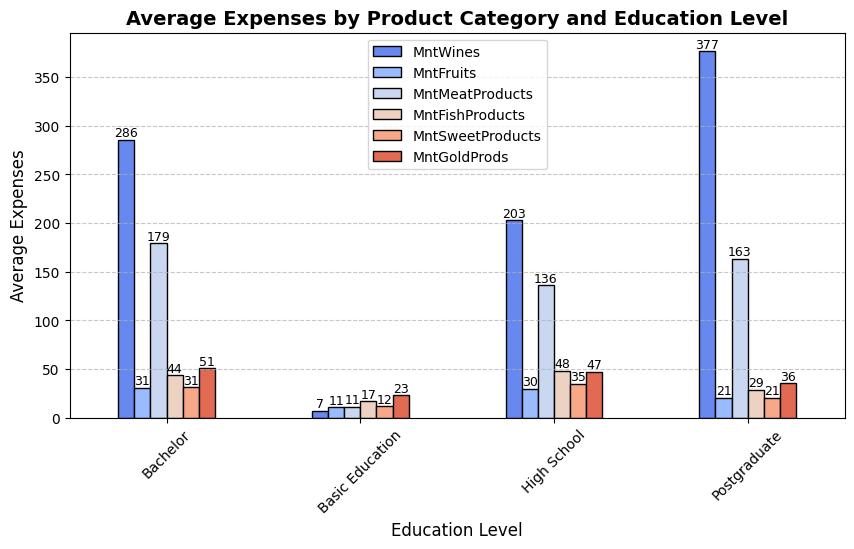

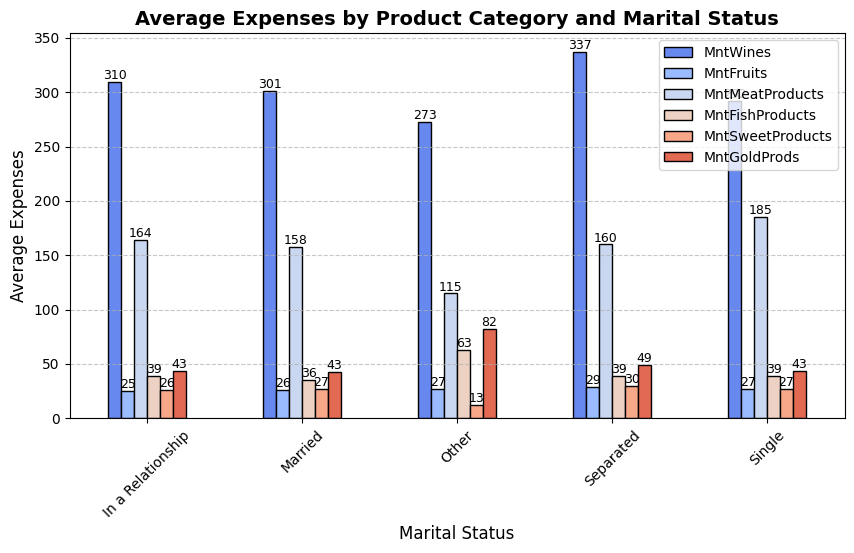

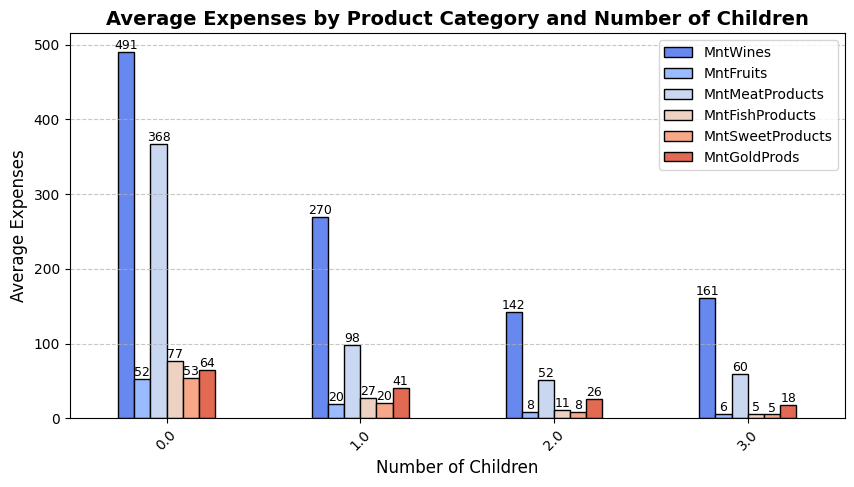

In [20]:
# Average expenses by product category and education level (cleaned)
product_spending_edu = df.groupby("Education_Status_Grouped")[['MntWines', 'MntFruits', 'MntMeatProducts', 
                                                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].mean()

# Average expenses by product category and marital status
product_spending_marital = df.groupby("Marital_Status_Grouped")[['MntWines', 'MntFruits', 'MntMeatProducts', 
                                                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].mean()

# Average expenses by product category and number of children
product_spending_children = df.groupby("Total_Children")[['MntWines', 'MntFruits', 'MntMeatProducts', 
                                                   'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].mean()

# Define modern color palettes
palette_edu = sns.color_palette("coolwarm", len(product_spending_edu.columns))
palette_marital = sns.color_palette("coolwarm", len(product_spending_marital.columns))
palette_children = sns.color_palette("coolwarm", len(product_spending_children.columns))

# Expenses by product category based on education level (cleaned)
ax_edu = product_spending_edu.plot(kind="bar", figsize=(10, 5), color=palette_edu, edgecolor="black")
plt.title("Average Expenses by Product Category and Education Level", fontsize=14, fontweight="bold")
plt.xlabel("Education Level", fontsize=12)
plt.ylabel("Average Expenses", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
for container in ax_edu.containers:
    for bar in container:
        height = bar.get_height()
        ax_edu.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', 
                    ha='center', va='bottom', fontsize=9, color='black')

plt.show()

# Expenses by product category based on marital status
ax_marital = product_spending_marital.plot(kind="bar", figsize=(10, 5), color=palette_marital, edgecolor="black")
plt.title("Average Expenses by Product Category and Marital Status", fontsize=14, fontweight="bold")
plt.xlabel("Marital Status", fontsize=12)
plt.ylabel("Average Expenses", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
for container in ax_marital.containers:
    for bar in container:
        height = bar.get_height()
        ax_marital.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', 
                        ha='center', va='bottom', fontsize=9, color='black')

plt.show()

# Expenses by product category based on number of children
ax_children = product_spending_children.plot(kind="bar", figsize=(10, 5), color=palette_children, edgecolor="black")
plt.title("Average Expenses by Product Category and Number of Children", fontsize=14, fontweight="bold")
plt.xlabel("Number of Children", fontsize=12)
plt.ylabel("Average Expenses", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
for container in ax_children.containers:
    for bar in container:
        height = bar.get_height()
        ax_children.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.0f}', 
                         ha='center', va='bottom', fontsize=9, color='black')

plt.show()

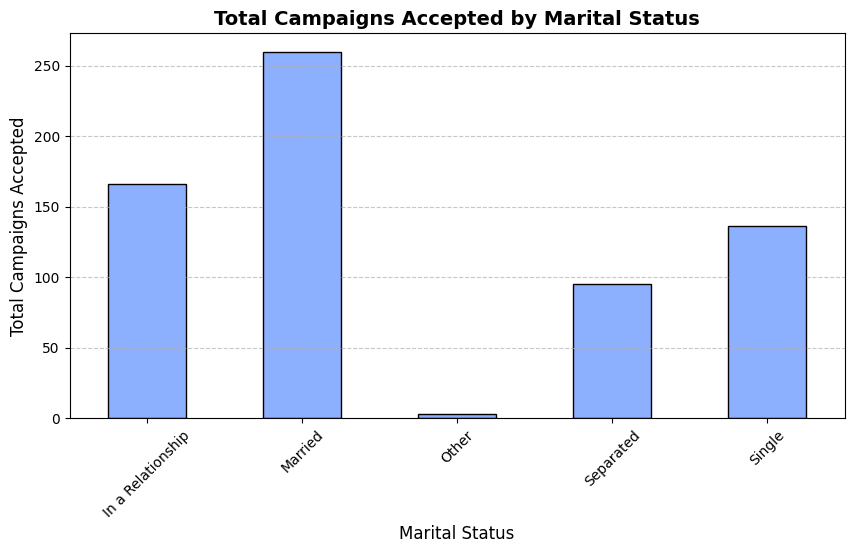

In [21]:
# Grouping by marital status and summing the total campaigns accepted
campaigns_marital = df.groupby("Marital_Status_Grouped")["Total_Campaigns_Accepted"].sum()

# Plotting
plt.figure(figsize=(10, 5))
campaigns_marital.plot(kind="bar", color=color1 , edgecolor="black")
plt.title("Total Campaigns Accepted by Marital Status", fontsize=14, fontweight="bold")
plt.xlabel("Marital Status", fontsize=12)
plt.ylabel("Total Campaigns Accepted", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

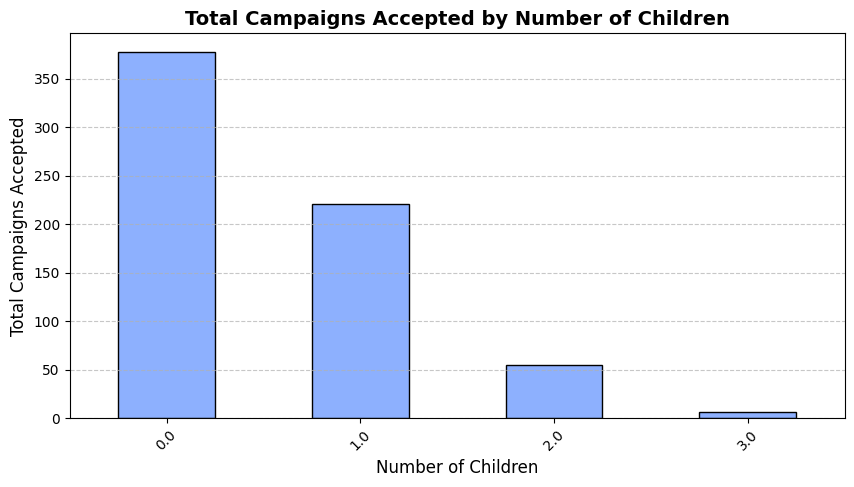

In [22]:
# Grouping by number of children and summing the total campaigns accepted
campaigns_children = df.groupby("Total_Children")["Total_Campaigns_Accepted"].sum()

# Plotting
plt.figure(figsize=(10, 5))
campaigns_children.plot(kind="bar", color=color1, edgecolor="black")
plt.title("Total Campaigns Accepted by Number of Children", fontsize=14, fontweight="bold")
plt.xlabel("Number of Children", fontsize=12)
plt.ylabel("Total Campaigns Accepted", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

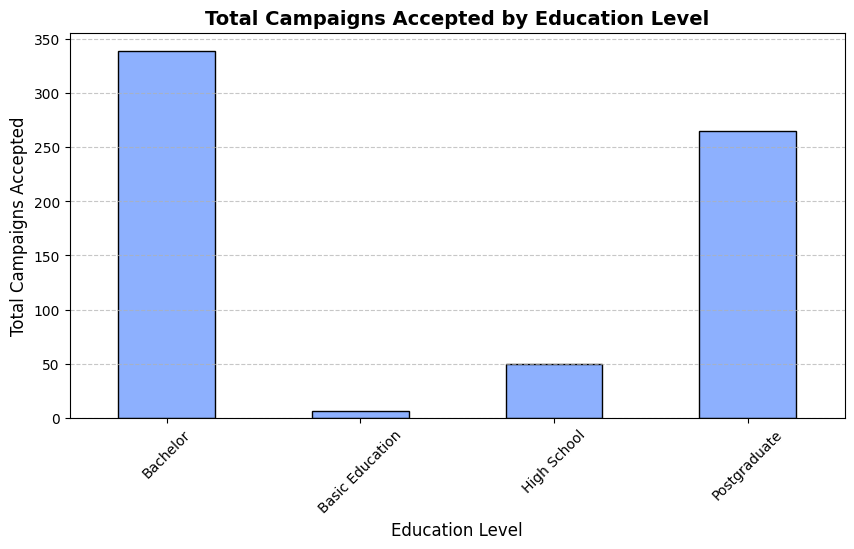

In [23]:
# Grouping by education level and summing the total campaigns accepted
campaigns_edu = df.groupby("Education_Status_Grouped")["Total_Campaigns_Accepted"].sum()

# Plotting
plt.figure(figsize=(10, 5))
campaigns_edu.plot(kind="bar", color=color1, edgecolor="black")
plt.title("Total Campaigns Accepted by Education Level", fontsize=14, fontweight="bold")
plt.xlabel("Education Level", fontsize=12)
plt.ylabel("Total Campaigns Accepted", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()

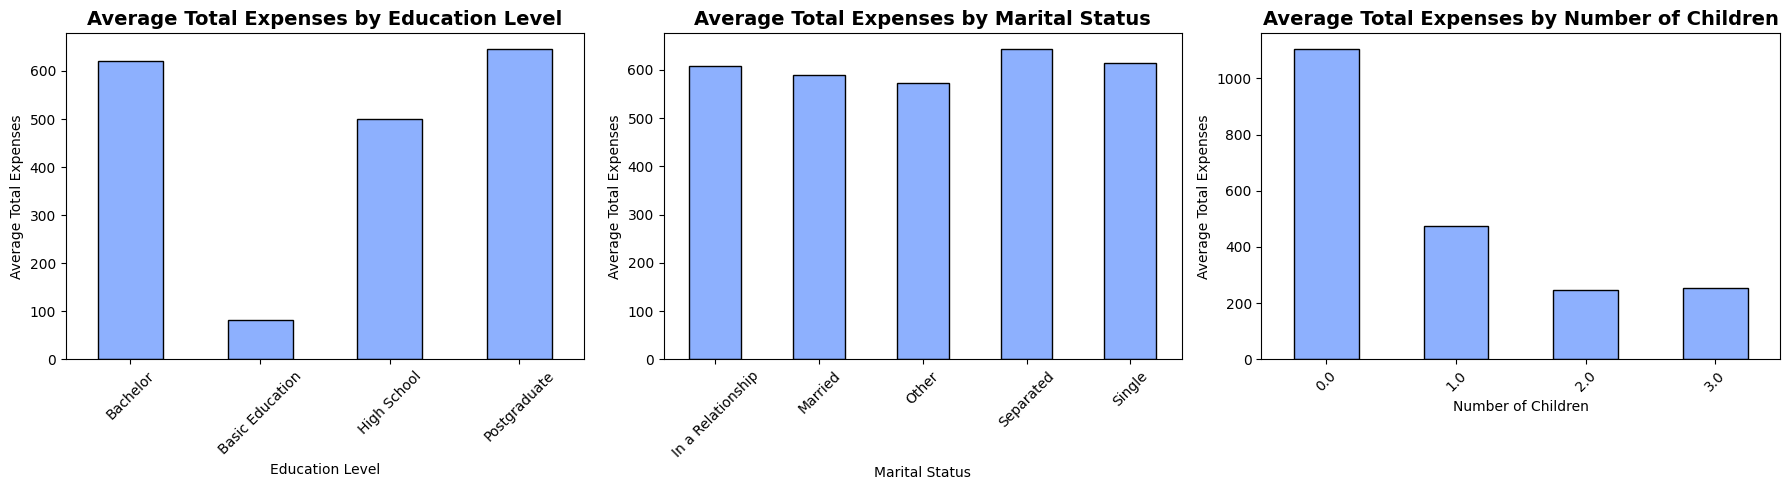

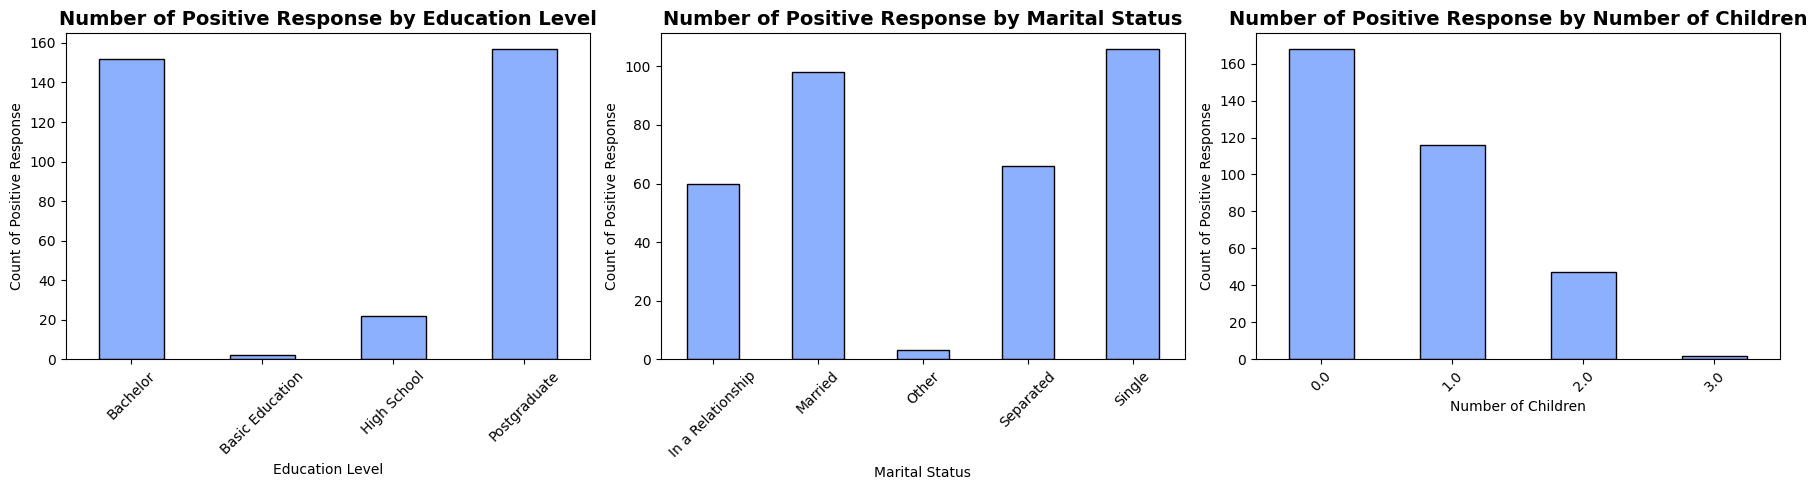

In [24]:
# Calculate total expenses
df["Total_Expenses"] = df[['MntWines', 'MntFruits', 'MntMeatProducts', 
                           'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum(axis=1)

# Group by Education, Marital Status, and Number of Children
expenses_edu = df.groupby("Education_Status_Grouped")["Total_Expenses"].mean()
expenses_marital = df.groupby("Marital_Status_Grouped")["Total_Expenses"].mean()
expenses_children = df.groupby("Total_Children")["Total_Expenses"].mean()

# Count of Response = 1
response_edu = df[df["Response"] == 1].groupby("Education_Status_Grouped")["Response"].count()
response_marital = df[df["Response"] == 1].groupby("Marital_Status_Grouped")["Response"].count()
response_children = df[df["Response"] == 1].groupby("Total_Children")["Response"].count()

# Define modern color palette
palette = sns.color_palette("coolwarm", 3)

# Plot Total Expenses
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

expenses_edu.plot(kind="bar", ax=axes[0], color=palette[0], edgecolor="black")
axes[0].set_title("Average Total Expenses by Education Level", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Education Level")
axes[0].set_ylabel("Average Total Expenses")
axes[0].tick_params(axis='x', rotation=45)

expenses_marital.plot(kind="bar", ax=axes[1], color=palette[0], edgecolor="black")
axes[1].set_title("Average Total Expenses by Marital Status", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Marital Status")
axes[1].set_ylabel("Average Total Expenses")
axes[1].tick_params(axis='x', rotation=45)

expenses_children.plot(kind="bar", ax=axes[2], color=palette[0], edgecolor="black")
axes[2].set_title("Average Total Expenses by Number of Children", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Number of Children")
axes[2].set_ylabel("Average Total Expenses")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Plot Response = 1 Counts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

response_edu.plot(kind="bar", ax=axes[0], color=palette[0], edgecolor="black")
axes[0].set_title("Number of Positive Response by Education Level", fontsize=14, fontweight="bold")
axes[0].set_xlabel("Education Level")
axes[0].set_ylabel("Count of Positive Response")
axes[0].tick_params(axis='x', rotation=45)

response_marital.plot(kind="bar", ax=axes[1], color=palette[0], edgecolor="black")
axes[1].set_title("Number of Positive Response by Marital Status", fontsize=14, fontweight="bold")
axes[1].set_xlabel("Marital Status")
axes[1].set_ylabel("Count of Positive Response")
axes[1].tick_params(axis='x', rotation=45)

response_children.plot(kind="bar", ax=axes[2], color=palette[0], edgecolor="black")
axes[2].set_title("Number of Positive Response by Number of Children", fontsize=14, fontweight="bold")
axes[2].set_xlabel("Number of Children")
axes[2].set_ylabel("Count of Positive Response")
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

Customers with higher education levels tend to have higher total expenses, likely due to greater financial stability and higher earning potential.  
Marital status appears to have minimal impact on spending, as customers across different relationship statuses exhibit similar average expenses.  
Families with more children tend to spend significantly less, likely due to budget constraints and the need to allocate resources more carefully.  
  
Customers with higher education levels tend to be more receptive to marketing, likely due to a greater interest in premium products and higher purchasing power.  
Marital status influences response rates, with single and married individuals showing the highest engagement, while other groups have lower acceptance rates.  
Households with fewer children are more engaged, with response rates declining as the number of children increases. This suggests that financial flexibility plays a significant role in purchasing decisions.

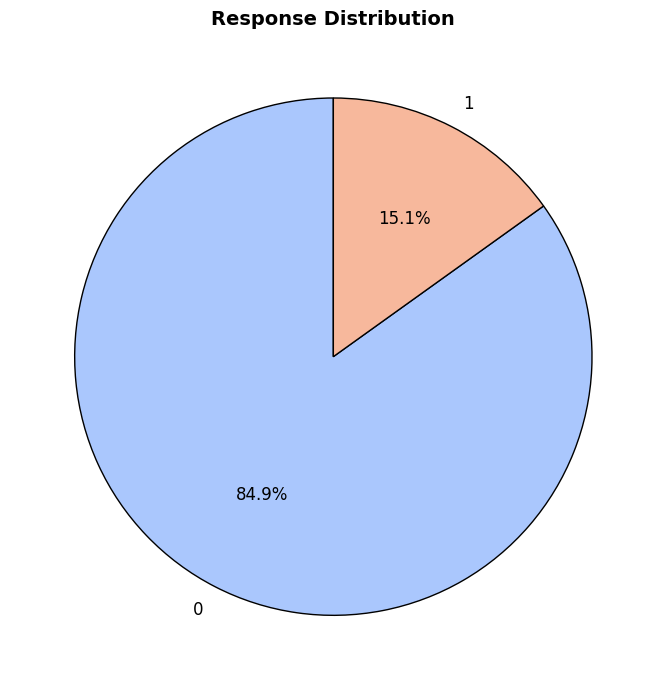

In [25]:
# Counting the responses
response_counts = df['Response'].value_counts()

# Defining colors using the "coolwarm" palette
colors = sns.color_palette("coolwarm", len(response_counts))

# Plotting the pie chart
plt.figure(figsize=(7, 7))
response_counts.plot.pie(
    autopct='%1.1f%%', 
    colors=colors, 
    startangle=90, 
    wedgeprops={"edgecolor": "black"},  # Border for better readability
    textprops={'fontsize': 12}  # More readable text
)

# Adding the title and removing ylabel
plt.title('Response Distribution', fontsize=14, fontweight="bold")
plt.ylabel('')

plt.tight_layout()
plt.show()

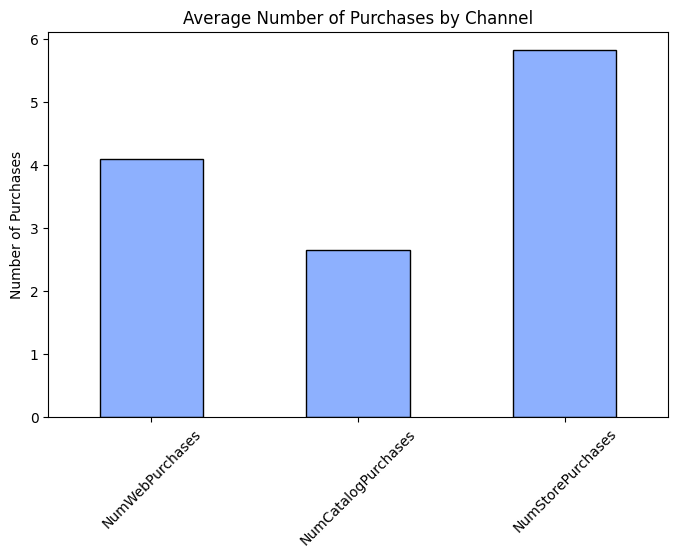

In [26]:
# Bar plot for online vs store purchases
df[['NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']].mean().plot(kind='bar', figsize=(8,5), color=couleur, edgecolor='black')
plt.title("Average Number of Purchases by Channel")
plt.ylabel("Number of Purchases")
plt.xticks(rotation=45)
plt.show()

# PART 2
## Market Segmentation with Self-Organizing Maps (Kohonen Maps). 
### Self Organizing Maps + K means

In [27]:
df

ID  Year_Birth   Education Marital_Status   Income  Kidhome  \
0      5524.0      1957.0  Graduation         Single  58138.0      0.0   
1      2174.0      1954.0  Graduation         Single  46344.0      1.0   
2      4141.0      1965.0  Graduation       Together  71613.0      0.0   
3      6182.0      1984.0  Graduation       Together  26646.0      1.0   
4      5324.0      1981.0         PhD        Married  58293.0      1.0   
...       ...         ...         ...            ...      ...      ...   
2235  10870.0      1967.0  Graduation        Married  61223.0      0.0   
2236   4001.0      1946.0         PhD       Together  64014.0      2.0   
2237   7270.0      1981.0  Graduation       Divorced  56981.0      0.0   
2238   8235.0      1956.0      Master       Together  69245.0      0.0   
2239   9405.0      1954.0         PhD        Married  52869.0      1.0   

      Teenhome Dt_Customer  Recency  MntWines  ...   Age  Customer_Since  \
0          0.0  2012-09-04     58.0     635.0  ...  68.0            4559   
1          1.0  2014-03-08     38.0      11.0  ...  71.0            4009   
2          0.0  2013-08-21     26.0     426.0  ...  60.0            4208   
3          0.0  2014-02-10     26.0      11.0  ...  41.0            4035   
4          0.0  2014-01-19     94.0     173.0  ...  44.0            4057   
...        ...         ...      ...       ...  ...   ...             ...   
2235       1.0  2013-06-13     46.0     709.0  ...  58.0            4277   
2236       1.0  2014-06-10     56.0     406.0  ...  79.0            3915   
2237       0.0  2014-01-25     91.0     908.0  ...  44.0            4051   
2238       1.0  2014-01-24      8.0     428.0  ...  69.0            4052   
2239       1.0  2012-10-15     40.0      84.0  ...  71.0            4518   

      Total_Children  Total_Spending  Online_Purchase_Ratio  \
0                0.0          1617.0               0.347826   
1                2.0            27.0               0.200000   
2                0.0           776.0               0.380952   
3                1.0            53.0               0.285714   
4                1.0           422.0               0.333333   
...              ...             ...                    ...   
2235             1.0          1341.0               0.529412   
2236             3.0           444.0               0.500000   
2237             0.0          1241.0               0.105263   
2238             1.0           843.0               0.272727   
2239             2.0           172.0               0.333333   

      Total_Campaigns_Accepted  Marital_Status_Grouped  \
0                          0.0                  Single   
1                          0.0                  Single   
2                          0.0       In a Relationship   
3                          0.0       In a Relationship   
4                          0.0                 Married   
...                        ...                     ...   
2235                       0.0                 Married   
2236                       1.0       In a Relationship   
2237                       1.0               Separated   
2238                       0.0       In a Relationship   
2239                       0.0                 Married   

      Education_Status_Grouped  Web_Visit_Category  Total_Expenses  
0                     Bachelor              Medium          1617.0  
1                     Bachelor              Medium            27.0  
2                     Bachelor                 Low           776.0  
3                     Bachelor              Medium            53.0  
4                 Postgraduate              Medium           422.0  
...                        ...                 ...             ...  
2235                  Bachelor              Medium          1341.0  
2236              Postgraduate              Medium           444.0  
2237                  Bachelor              Medium          1241.0  
2238              Postgraduate                 Low           843.

In [28]:
# Selecting features for segmentation
# Label Encoding for Marital Status
le = LabelEncoder()
df['Marital_Status_Grouped_Encoded'] = le.fit_transform(df['Marital_Status_Grouped'])

df['Education_Status_Grouped_Encoded'] = le.fit_transform(df['Education_Status_Grouped'])

print(df.head())

       ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524.0      1957.0  Graduation         Single  58138.0      0.0       0.0   
1  2174.0      1954.0  Graduation         Single  46344.0      1.0       1.0   
2  4141.0      1965.0  Graduation       Together  71613.0      0.0       0.0   
3  6182.0      1984.0  Graduation       Together  26646.0      1.0       0.0   
4  5324.0      1981.0         PhD        Married  58293.0      1.0       0.0   

  Dt_Customer  Recency  MntWines  ...  Total_Children  Total_Spending  \
0  2012-09-04     58.0     635.0  ...             0.0          1617.0   
1  2014-03-08     38.0      11.0  ...             2.0            27.0   
2  2013-08-21     26.0     426.0  ...             0.0           776.0   
3  2014-02-10     26.0      11.0  ...             1.0            53.0   
4  2014-01-19     94.0     173.0  ...             1.0           422.0   

   Online_Purchase_Ratio  Total_Campaigns_Accepted  Marital_Status_Grouped  \
0 

In [29]:
df.columns

Index(['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome',
       'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1',
       'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response',
       'Age', 'Customer_Since', 'Total_Children', 'Total_Spending',
       'Online_Purchase_Ratio', 'Total_Campaigns_Accepted',
       'Marital_Status_Grouped', 'Education_Status_Grouped',
       'Web_Visit_Category', 'Total_Expenses',
       'Marital_Status_Grouped_Encoded', 'Education_Status_Grouped_Encoded'],
      dtype='object')

In [30]:
# Selecting the relevant features
features = ['Age', 'Income', 'Total_Spending', 'NumWebPurchases', 'NumStorePurchases', 
            'NumCatalogPurchases', 'NumWebVisitsMonth', 'Total_Campaigns_Accepted', 
            'Total_Children', 'Recency', 'Marital_Status_Grouped_Encoded', 
            'Education_Status_Grouped_Encoded',  
            'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']


# Normalizing the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[features])

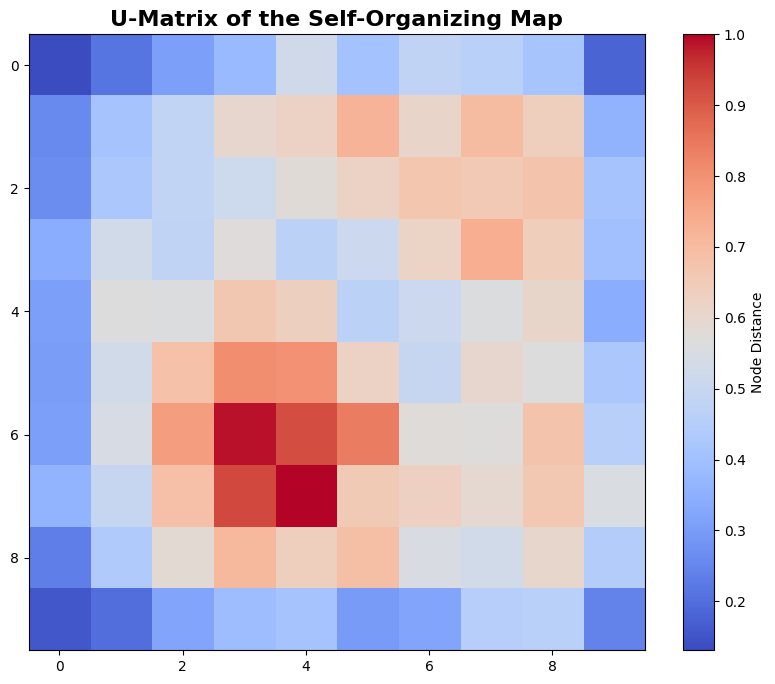

In [31]:
# Applying a SOM (Self-Organizing Map)
som_shape = (10, 10)  # Grid shape for SOM
som = MiniSom(som_shape[0], som_shape[1], len(features), sigma=1.0, learning_rate=0.5, random_seed=42)
som.random_weights_init(scaled_data)
som.train_random(scaled_data, 1000)

# Plotting the U-Matrix
u_matrix = som.distance_map()

plt.figure(figsize=(10, 8))
plt.title("U-Matrix of the Self-Organizing Map", fontsize=16, fontweight='bold')
plt.imshow(u_matrix, cmap='coolwarm')
plt.colorbar(label="Node Distance")
plt.show()

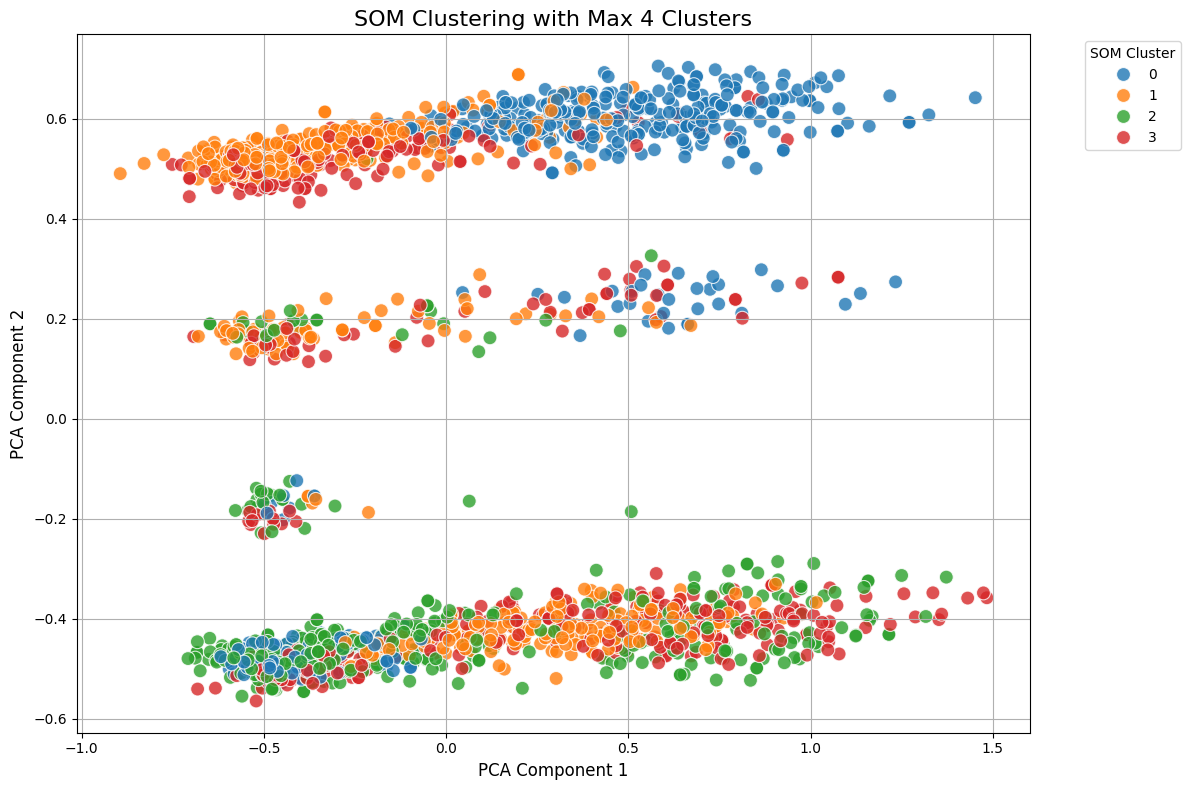

                   Age        Income  Total_Spending  NumWebPurchases  \
SOM_Cluster                                                             
0            56.784133  56470.953875      845.747232         4.461255   
1            56.320755  49637.537736      490.202830         4.297170   
2            54.491453  48725.085470      522.722222         3.698718   
3            56.515206  51604.021467      578.254025         3.864043   

             NumStorePurchases  NumCatalogPurchases  NumWebVisitsMonth  \
SOM_Cluster                                                              
0                     6.690037             3.413284           5.007380   
1                     5.737421             2.305031           5.715409   
2                     5.040598             2.211538           5.553419   
3                     5.737030             2.651163           5.044723   

             Total_Campaigns_Accepted  Total_Children    Recency  \
SOM_Cluster                                     

In [32]:
# Step 2: Find the winning nodes for each data point
winning_nodes = np.array([som.winner(x) for x in scaled_data])

# Step 3: Create clusters based on the winning nodes (for KMeans)
# You can use the row and column indices of the winning nodes as identifiers for clusters
winning_nodes_flat = [som._weights.shape[0] * w[0] + w[1] for w in winning_nodes]

# Convert winning_nodes_flat to a numpy array for reshaping
winning_nodes_flat = np.array(winning_nodes_flat).reshape(-1, 1)  # Convert to numpy array and reshape

# Step 4: Apply KMeans clustering to the winning nodes with a maximum number of clusters (e.g., 4)
n_max_clusters = 4  # Maximum number of clusters
kmeans = KMeans(n_clusters=n_max_clusters, random_state=42)
df['SOM_Cluster'] = kmeans.fit_predict(winning_nodes_flat)  # Fit KMeans to the winning nodes

# Step 5: Visualize the clusters in 2D using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=pca_result[:, 0],
    y=pca_result[:, 1],
    hue=df['SOM_Cluster'],  # Color by SOM cluster
    palette='tab10',
    alpha=0.8,
    s=100
)

plt.title("SOM Clustering with Max 4 Clusters", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.legend(title="SOM Cluster", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# You can also examine the clusters by calculating the mean values of features per cluster
cluster_summary = df.groupby('SOM_Cluster')[features].mean()
print(cluster_summary)

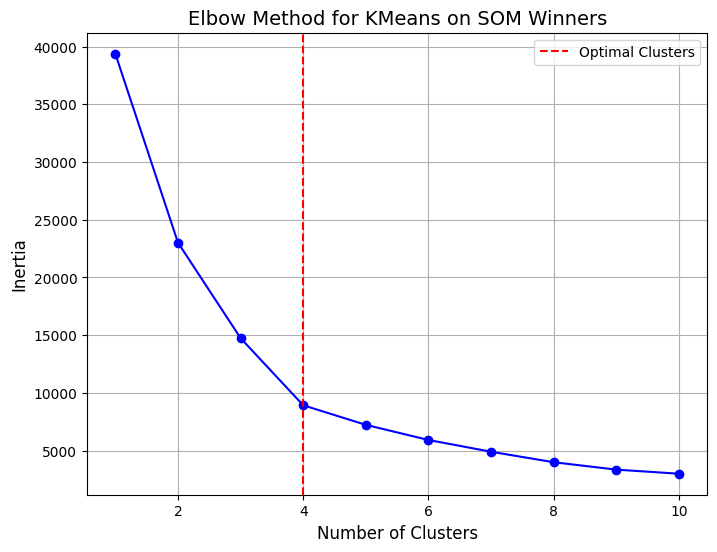

In [33]:
# **1. KMeans sui nodi vincitori della SOM**
winners = np.array([som.winner(x) for x in scaled_data])  # Troviamo il nodo vincitore per ogni dato

# Determinare il numero ottimale di cluster con il metodo del gomito
inertia = []
cluster_range = range(1, 11)
for n_clusters in cluster_range:
    kmeans_temp = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans_temp.fit(winners)
    inertia.append(kmeans_temp.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia, marker='o', color='b')
plt.axvline(x=4, color='r', linestyle='--', label="Optimal Clusters")
plt.title("Elbow Method for KMeans on SOM Winners", fontsize=14)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Inertia", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

The optimal number of clusters, based on the elbow method analysis and the visualization of the segmented data through PCA and K-Means, was found to be 4, as it provides a clear separation of the groups.

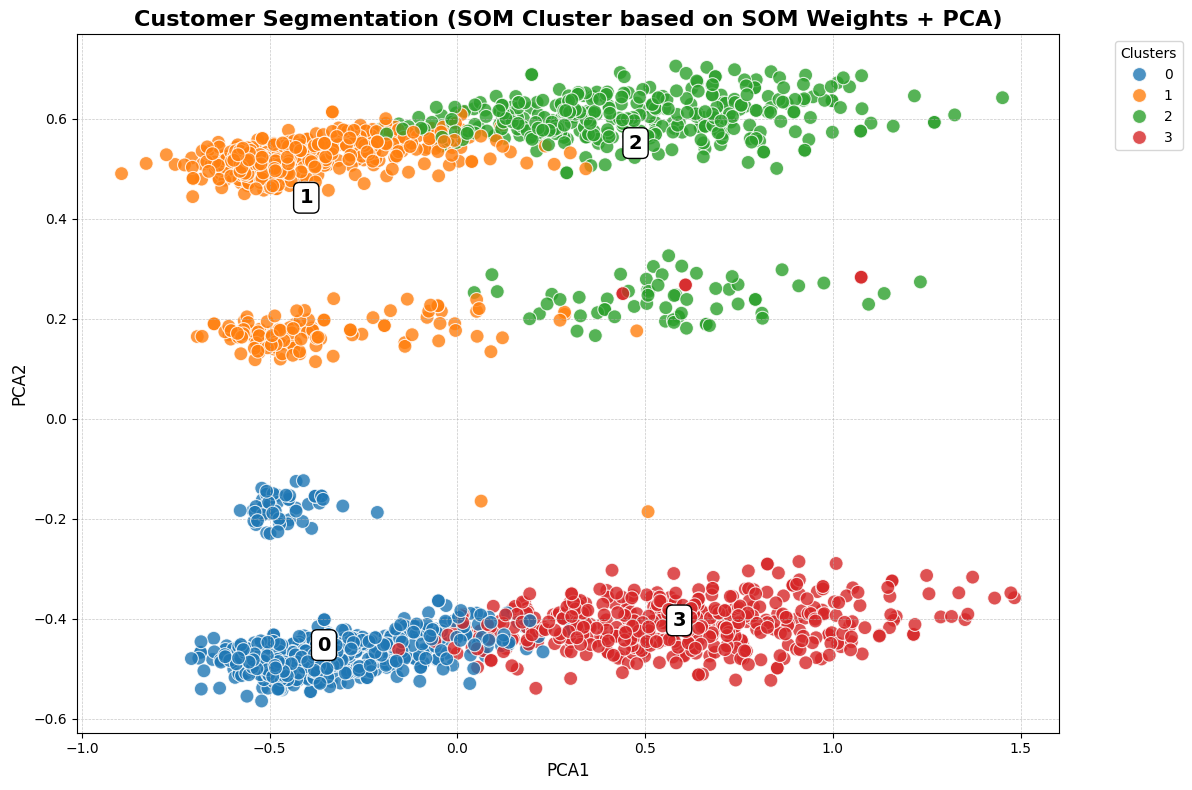


 Summary of SOM Clusters based on Weights:
                           Age        Income  Total_Spending  NumWebPurchases  \
SOM_Cluster_Weights                                                             
0                    53.899270  36333.118248      168.886131         2.864234   
1                    55.927750  40163.481117      186.362890         3.068966   
2                    59.065574  70368.625293     1222.236534         5.768150   
3                    56.795455  71139.607438     1212.737603         5.677686   

                     NumStorePurchases  NumCatalogPurchases  \
SOM_Cluster_Weights                                           
0                             3.743066             0.833577   
1                             3.883415             0.990148   
2                             8.826698             5.009368   
3                             8.559917             5.206612   

                     NumWebVisitsMonth  Total_Campaigns_Accepted  \
SOM_Cluster_Weights   

In [34]:
# Applichiamo KMeans ai vincitori della SOM
n_som_clusters = 4
kmeans_som = KMeans(n_clusters=n_som_clusters, random_state=42, n_init=10)
df["SOM_Cluster"] = kmeans_som.fit_predict(winners)

# 1. Applicazione di KMeans sui pesi della SOM
weights = som.get_weights().reshape(-1, len(features))  # Trasformiamo i pesi in un array 2D

# KMeans sui pesi della SOM per ottenere i cluster dei neuroni
kmeans_weights = KMeans(n_clusters=n_som_clusters, random_state=42, n_init=10)
som_weights_clusters = kmeans_weights.fit_predict(weights)  # Clustering dei neuroni

# 2. Associare il cluster dei neuroni a ciascun dato in base al vincitore del nodo
# Troviamo il nodo vincitore per ogni dato nel dataset
winners = np.array([som.winner(x) for x in scaled_data])

# Creiamo una nuova colonna che associa il cluster del nodo vincitore
df["SOM_Cluster_Weights"] = [som_weights_clusters[som.winner(x)[0] * som_shape[1] + som.winner(x)[1]] for x in scaled_data]

# 3. Visualizzare i cluster in 2D usando PCA
pca = PCA(n_components=2)
pca_results = pca.fit_transform(scaled_data)

# Visualizziamo i risultati
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_results[:, 0], y=pca_results[:, 1], hue=df["SOM_Cluster_Weights"], palette="tab10", alpha=0.8, s=100)

# Annotiamo il centro di ogni cluster
for cluster_id in df["SOM_Cluster_Weights"].unique():
    cluster_data = pca_results[df["SOM_Cluster_Weights"] == cluster_id]
    cluster_center = cluster_data.mean(axis=0)
    plt.text(cluster_center[0], cluster_center[1], 
             str(cluster_id), fontsize=14, fontweight='bold', 
             ha='center', va='center', color='black', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.title("Customer Segmentation (SOM Cluster based on SOM Weights + PCA)", fontsize=16, fontweight='bold')
plt.xlabel("PCA1", fontsize=12)
plt.ylabel("PCA2", fontsize=12)
plt.legend(title="Clusters", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

# **4. Analisi statistica per i cluster**
som_cluster_summary = df.groupby("SOM_Cluster_Weights")[features].mean()
print("\n Summary of SOM Clusters based on Weights:")
print(som_cluster_summary)

### Segment Interpretation

| **Cluster** | **Description** |
|------------|---------------|
| **0** | **Lower-income, low spending with a focus on wine and meat** – Average age around 54 years, low spending both online and in-store, with limited response to marketing campaigns. Frequent website visits, but overall spending remains low, primarily on wine and meat. |
| **1** | **Moderate-income, moderate-spending wine enthusiasts** – Average age around 56 years, moderate spending on wine, with low engagement in marketing campaigns. Frequent purchases across multiple channels, but total spending remains modest. |
| **2** | **High-income, high-spending across multiple categories** – Average age around 59 years, high spending across wine, meat, fish, sweets, and gold. Strong participation in marketing campaigns and purchases across different channels. |
| **3** | **High-income, high-spending across multiple categories (especially wine, meat, and gold)** – Average age around 57 years, the highest income (~$71k), with high spending across multiple categories. Strong engagement in marketing campaigns and frequent purchases across different channels. |

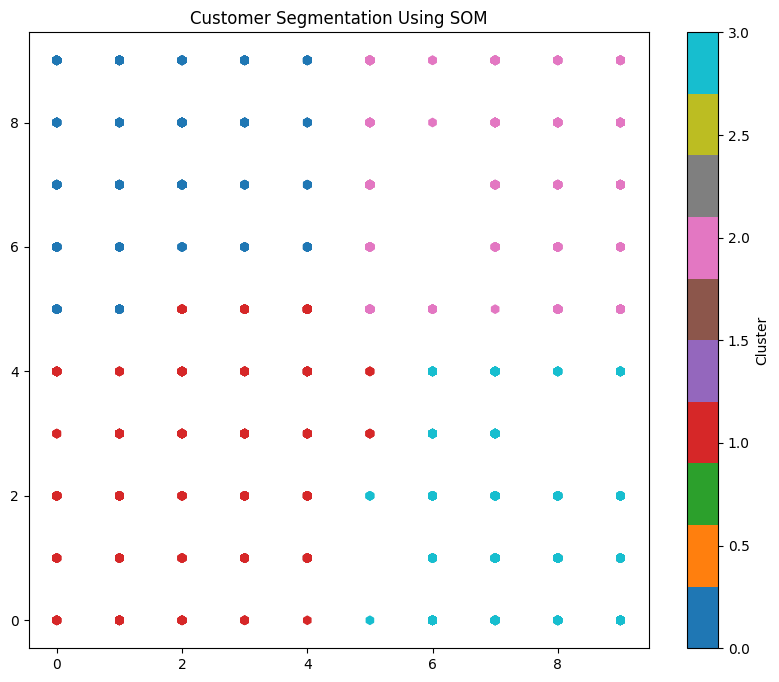

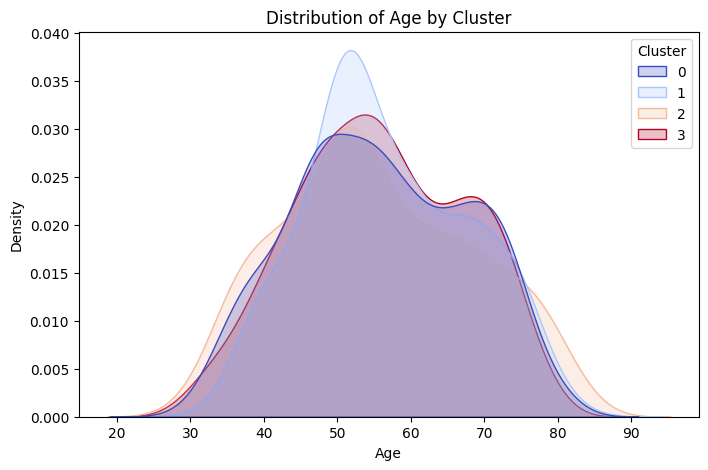

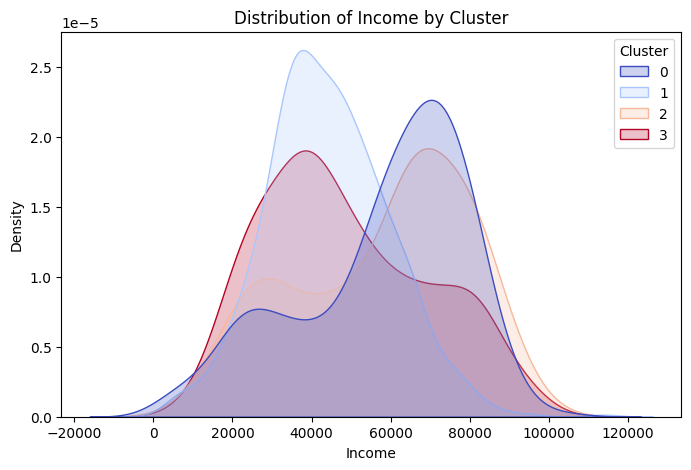

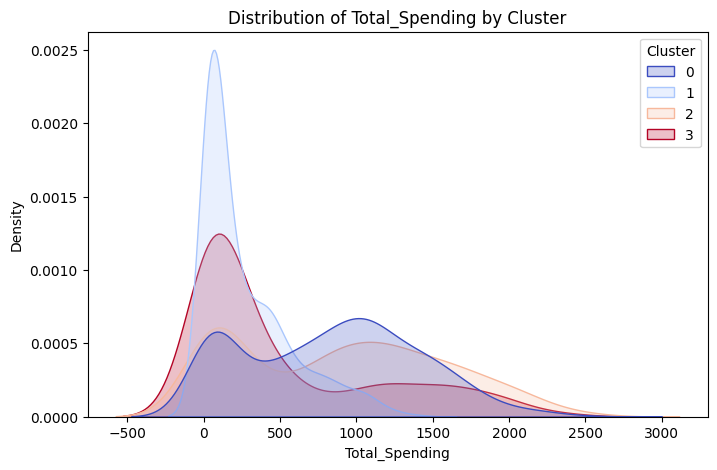

In [35]:
kmeans_som.fit(winners)
cluster_labels = kmeans_som.labels_

# Assign clusters to original data
df['Cluster'] = cluster_labels

# Create a SOM cluster visualization
plt.figure(figsize=(10, 8))
plt.scatter(winners[:, 0], winners[:, 1], c=cluster_labels, cmap='tab10', marker='h')
plt.colorbar(label="Cluster")
plt.title("Customer Segmentation Using SOM")
plt.show()

# Feature Density Plots
features_to_plot = ['Age', 'Income', 'Total_Spending'] 

# Modify the feature plotting to use the updated Cluster labels
for feature in features_to_plot:
    plt.figure(figsize=(8, 5))
    sns.kdeplot(data=df, x=feature, hue='Cluster', fill=True, common_norm=False, palette="coolwarm")
    plt.title(f'Distribution of {feature} by Cluster')
    plt.show()

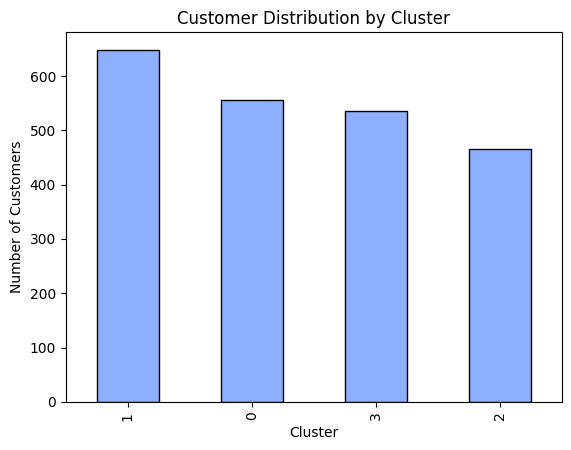

In [36]:
df['Cluster'].value_counts().plot(kind='bar', color=couleur,  edgecolor='black')
plt.xlabel("Cluster")
plt.ylabel("Number of Customers")
plt.title("Customer Distribution by Cluster")
plt.show()

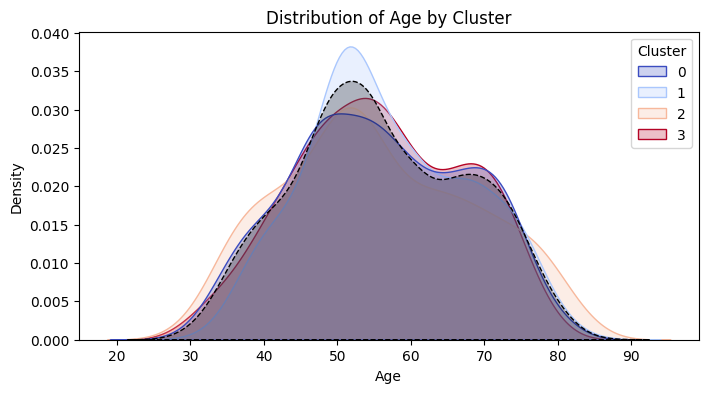

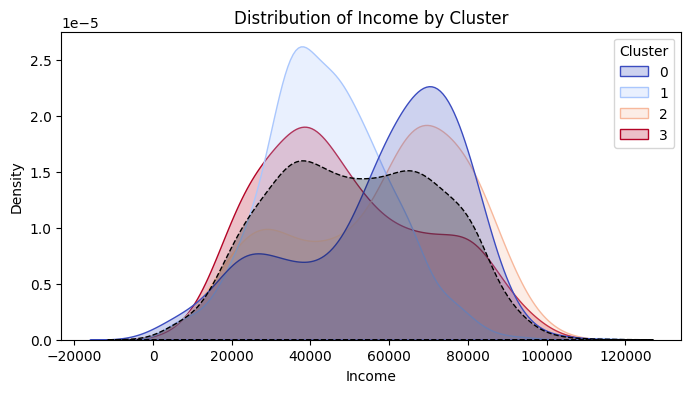

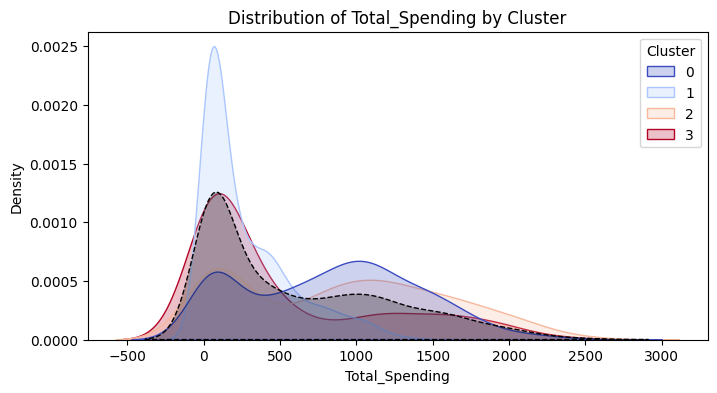

In [37]:
def plot_distribution(df, variable):
    plt.figure(figsize=(8, 4))
    
    # Plot KDE for each cluster
    sns.kdeplot(data=df, x=variable, hue="Cluster", fill=True, common_norm=False, palette="coolwarm")
    
    # Overlay KDE for the entire dataset
    sns.kdeplot(df[variable], color='black', linestyle='dashed', label="Population", fill=True)
    
    plt.title(f'Distribution of {variable} by Cluster')
  #  plt.legend()
    plt.show()

# Apply to all features of interest
for feature in ['Age', 'Income', 'Total_Spending']:
    plot_distribution(df, feature)

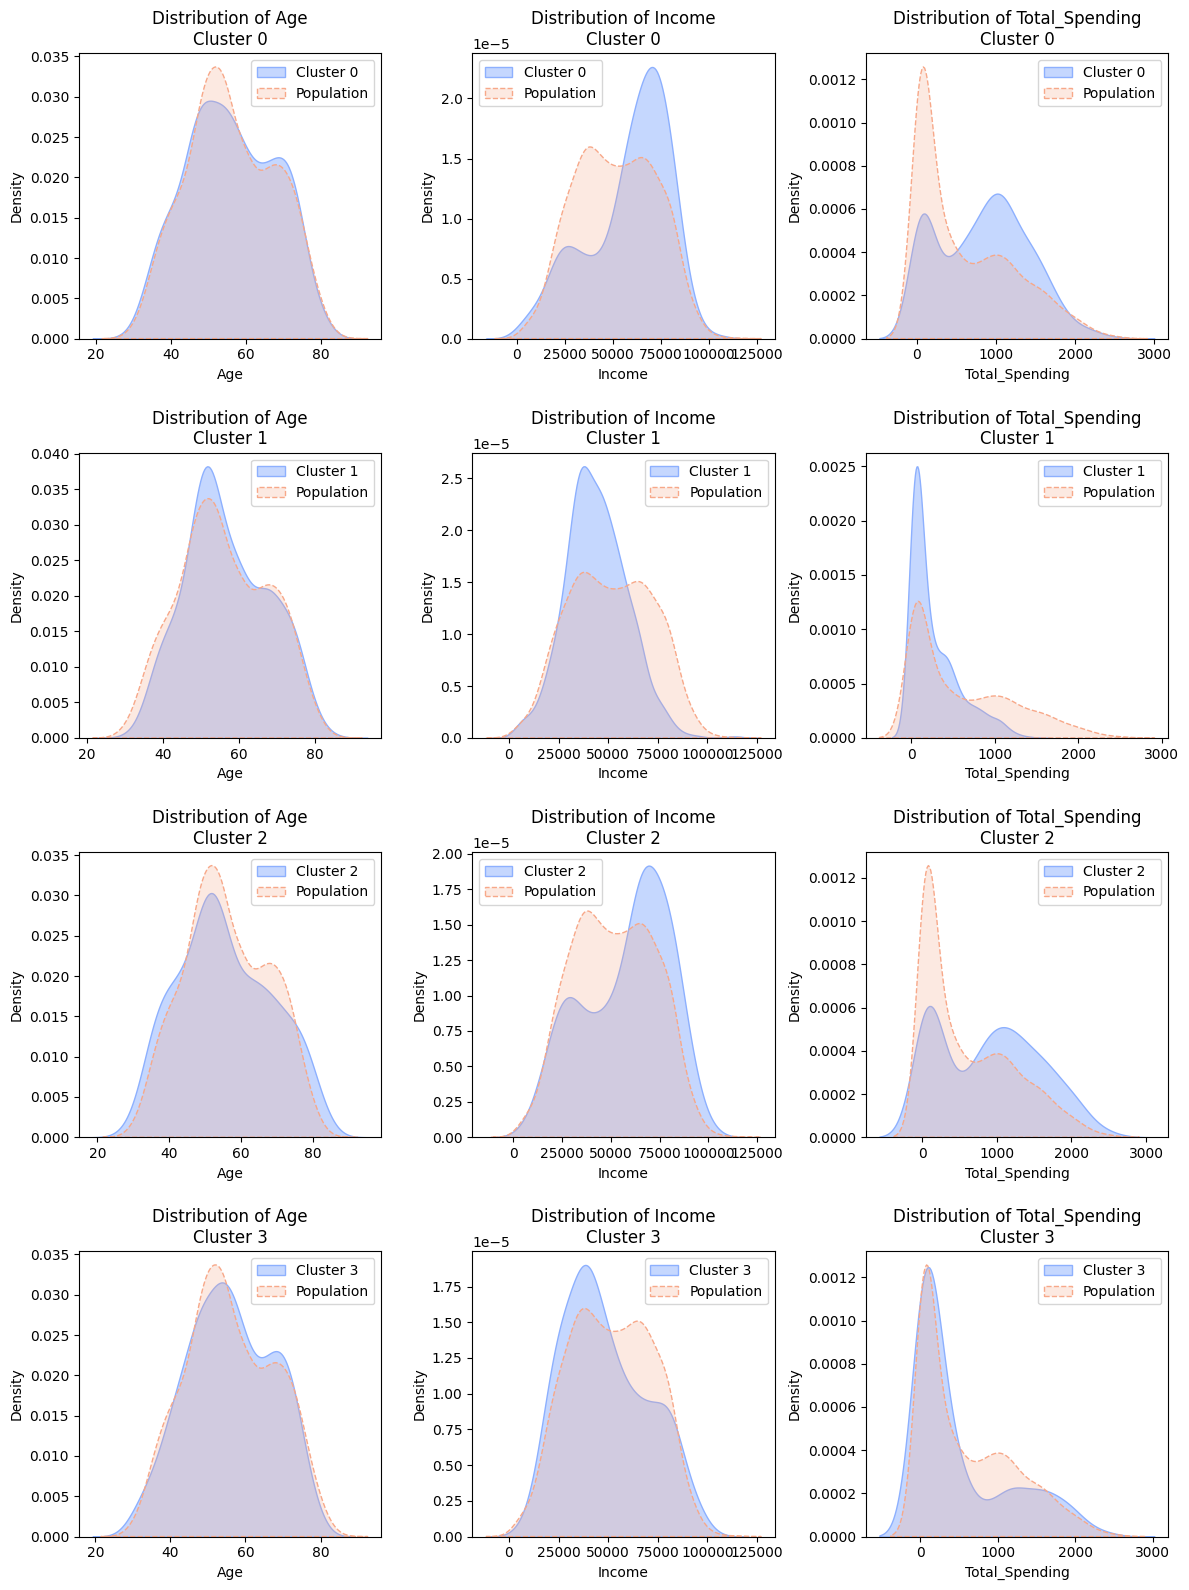

In [38]:
color1 = (0.5543118699137254, 0.6900970112156862, 0.9955155482352941)
color2 = (0.9673165156666667, 0.6574708288078431, 0.5381601507294118)

def plot_distribution_per_cluster(df, features):
    unique_clusters = sorted(df['Cluster'].unique())  # Sort to ensure consistent order
    num_clusters = len(unique_clusters)
    num_features = len(features)
    
    # Modifica il figsize per fare i grafici più stretti
    fig, axes = plt.subplots(num_clusters, num_features, figsize=(4 * num_features, 4 * num_clusters))  # ridotto 5 a 3
    
    for i, cluster in enumerate(unique_clusters):
        for j, feature in enumerate(features):
            ax = axes[i, j] if num_clusters > 1 else axes[j]  # Handle single-row case
            
            # KDE plot for the specific cluster
            sns.kdeplot(df[df['Cluster'] == cluster][feature], fill=True, color=color1, alpha=0.5, label=f'Cluster {cluster}', ax=ax)
            
            # KDE plot for the general population
            sns.kdeplot(df[feature], color=color2, linestyle='dashed', label="Population", fill=True, ax=ax)
            
            ax.set_title(f'Distribution of {feature}\nCluster {cluster}')
            ax.legend()
    
    # Puoi usare un po' di aggiustamenti per la spaziatura se necessario
    plt.tight_layout()
    # Aggiungi uno stretto spazio tra i grafici
    plt.subplots_adjust(wspace=0.3, hspace=0.4)
    
    plt.show()

# Apply the function with the selected features
features = ['Age', 'Income', 'Total_Spending']
plot_distribution_per_cluster(df, features)

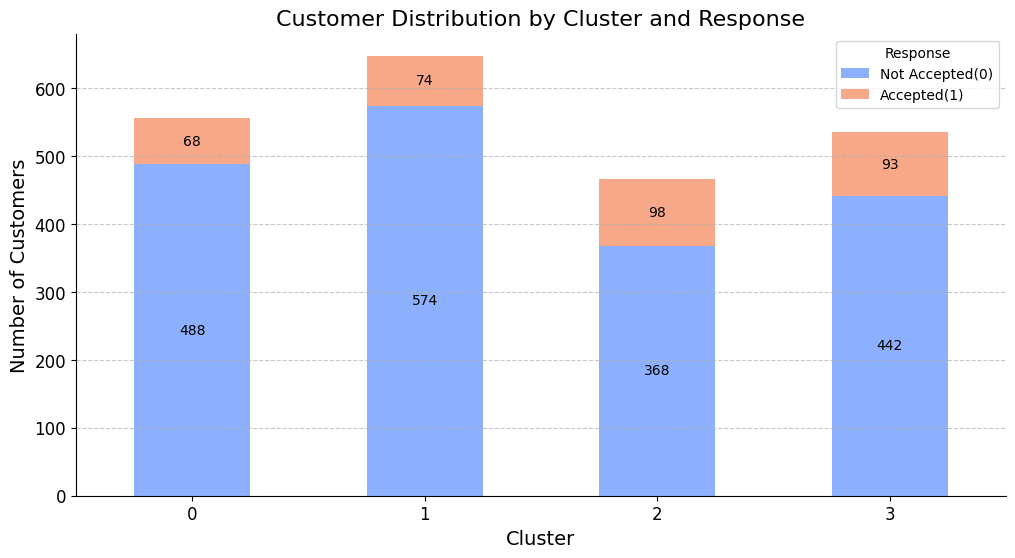

In [39]:
# Define colors
colors = [(0.554, 0.690, 0.996), (0.967, 0.657, 0.538)]

# Group by Cluster and Response to count occurrences
cluster_response_counts = df.groupby(['Cluster', 'Response']).size().unstack(fill_value=0)

# Create the stacked bar chart
ax = cluster_response_counts.plot(kind='bar', stacked=True, color=colors, figsize=(12, 6))

# Add labels and title
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Number of Customers", fontsize=14)
plt.title("Customer Distribution by Cluster and Response", fontsize=16)

# Add legend and formatting
plt.legend(title="Response", labels=["Not Accepted(0)", "Accepted(1)"])
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)

# Remove top and right borders for a cleaner look
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add grid lines on the Y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add values on the bars
for i, bars in enumerate(plt.gca().containers):
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, int(height), 
                     ha='center', va='center', fontsize=10, color='black')

# Display the chart
plt.show()

In [40]:
# Calculate the mean of the continuous variables for each cluster
mean_values = df.groupby('Cluster')[['Income', 'Total_Spending', 'Age', 'Recency']].mean()

# Count the responses per cluster
response_counts = df.groupby('Cluster')['Response'].value_counts().unstack(fill_value=0)

# Rename the columns for clarity
response_counts.columns = ['Not Accepted(0)', 'Accepted(1)']

# Combine the means and counts into a single table
result = pd.concat([mean_values, response_counts], axis=1)

# Display the final table
result

Income  Total_Spending        Age    Recency  Not Accepted(0)  \
Cluster                                                                        
0        58082.082734      837.136691  55.906475  45.386691              488   
1        44111.354938      270.813272  56.820988  46.087963              574   
2        57884.094421      897.472103  55.566524  51.178112              368   
3        48551.280374      521.280374  55.874766  54.422430              442   

         Accepted(1)  
Cluster               
0                 68  
1                 74  
2                 98  
3                 93

## Customer Segments Summary

### 0. **Moderately Engaged High-Income**
- **Income**: High (around 58,082)
- **Spending**: Moderate-high (around 837)
- **Age**: Middle-aged (55.91 years)
- **Offer Acceptance**: Moderate (68 accepted offers)
- **Key Traits**: Middle-aged individuals with moderate income and spending. They show a decent level of engagement, but their offer acceptance rate is moderate, indicating they may need more personalized or appealing offers to increase engagement.

**Summary**: This segment represents *"Moderately Engaged Middle-Income"* customers. They are financially stable but might need more tailored or attractive offers to increase their offer acceptance rate.

---

### 1. **Budget-Conscious Rejecters**
- **Income**: Low (around 44,111)
- **Spending**: Very low (around 271)
- **Age**: Middle-aged (56.82 years)
- **Offer Acceptance**: Low (74 accepted offers)
- **Key Traits**: Customers with lower income and minimal spending. They show some engagement but have a low acceptance rate for offers, possibly due to affordability or lack of interest in the offers provided.

**Summary**: This group can be described as *"Budget-Conscious Rejecters."* They tend to reject offers more often, and businesses may need to offer more affordable, value-driven options to appeal to them.

---

### 2. **Affluent Selective Shoppers**
- **Income**: High (around 57,884)
- **Spending**: High (around 897)
- **Age**: Middle-aged (55.57 years)
- **Offer Acceptance**: Moderate to High (98 accepted offers)
- **Key Traits**: High-income, high-spending customers with good engagement rates. They are discerning shoppers who may prefer high-quality, exclusive offers. Despite high spending, they show moderate to high offer acceptance, indicating selectivity in their choices.

**Summary**: This group represents *"Affluent Selective Shoppers."* They have significant purchasing power and engage with offers but may require premium, exclusive products or personalized deals to increase acceptance rates.

---

### 3. **Middle-Income Low Spenders**
- **Income**: Moderate (around 48,551)
- **Spending**: Low (around 521)
- **Age**: Middle-aged (55.87 years)
- **Offer Acceptance**: Low (93 accepted offers)
- **Key Traits**: Middle-income individuals who have low spending habits. Despite engaging somewhat with offers, they have a low acceptance rate, indicating a need for better-aligned, value-driven offers to increase spending.

**Summary**: These are *"Middle-Income Low Spenders,"* who may need more compelling offers or better alignment with their preferences to drive spending.

---

## Recap of Customer Segments with Names:
0. **Moderately Engaged High-Income**: Middle-aged individuals with moderate income, moderate spending, and moderate offer acceptance.
1. **Budget-Conscious Rejecters**: Low-income, low-spending individuals with a low acceptance rate for offers.
2. **Affluent Selective Shoppers**: High-income, high-spending, discerning customers with selective offer acceptance.
3. **Middle-Income Low Spenders**: Middle-income, low-spending individuals who need more compelling offers to increase spending.

# PART 3
## Compare two different prediction models for the variable response. Use different graphical techniques to compare the model. 

In [41]:
# Define a dictionary mapping the old column names to new ones
column_renames = {
    'Age': 'Customer_Age',
    'Income': 'Annual_Income',
    'Total_Spending': 'Total_Expenditure',
    'NumWebPurchases': 'Online_Purchases',
    'NumStorePurchases': 'In_Store_Purchases',
    'NumCatalogPurchases': 'Catalog_Purchases',
    'NumWebVisitsMonth': 'Monthly_Web_Visits',
    'Total_Campaigns_Accepted': 'Accepted_Campaigns_Count',
    'Total_Children': 'Number_of_Children',
    'Recency': 'Last_Purchase_Days',
    'Marital_Status_Grouped_Encoded': 'Marital_Status_Encoded',
    'Education_Status_Grouped_Encoded': 'Education_Level_Encoded',
    'MntWines': 'Spending_on_Wine',
    'MntFruits': 'Spending_on_Fruits',
    'MntMeatProducts': 'Spending_on_Meat',
    'MntFishProducts': 'Spending_on_Fish',
    'MntSweetProducts': 'Spending_on_Sweets',
    'MntGoldProds': 'Spending_on_Gold'
}

# Renaming the columns in your DataFrame df
df.rename(columns=column_renames, inplace=True)

Optimizing Random Forest...
Best model Random Forest: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       562
           1       0.62      0.49      0.55       100

    accuracy                           0.88       662
   macro avg       0.77      0.72      0.74       662
weighted avg       0.87      0.88      0.87       662

AUC-ROC Score: 0.8779


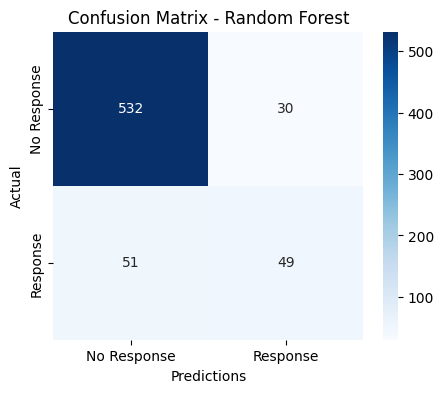

Optimizing SVM...
Best model SVM: {'C': 10, 'kernel': 'rbf'}

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.90      0.91       562
           1       0.49      0.55      0.52       100

    accuracy                           0.85       662
   macro avg       0.70      0.72      0.71       662
weighted avg       0.85      0.85      0.85       662

AUC-ROC Score: 0.8494


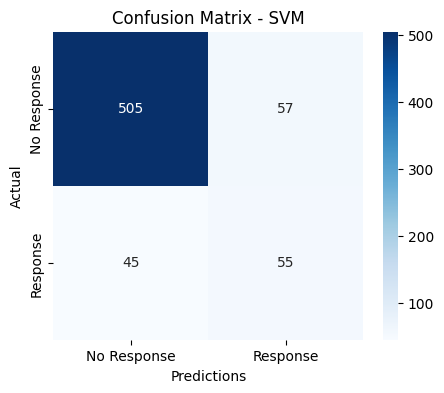


The best model is: Random Forest


In [42]:
# Selecting the features with new names
selected_features = [
    'Customer_Age', 'Annual_Income', 'Total_Expenditure', 'Online_Purchases', 'In_Store_Purchases',
    'Catalog_Purchases', 'Monthly_Web_Visits', 'Accepted_Campaigns_Count',
    'Number_of_Children', 'Last_Purchase_Days', 'Marital_Status_Encoded',
    'Education_Level_Encoded', 'Spending_on_Wine', 'Spending_on_Fruits', 'Spending_on_Meat', 
    'Spending_on_Fish', 'Spending_on_Sweets', 'Spending_on_Gold'
]

X = df[selected_features]
y = df["Response"]

# Train/test split (with stratification)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Standardization after the split (to avoid bias)
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Defining models and hyperparameter grids
models = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [50, 100, 200],
            "max_depth": [None, 10, 20],
            "min_samples_split": [2, 5, 10],
            "min_samples_leaf": [1, 2, 4]
        }
    },
    "SVM": {
        "model": SVC(probability=True, random_state=42),
        "params": {
            "C": [0.1, 1, 10],
            "kernel": ["linear", "rbf"]
        }
    }
}

# Training and evaluating the models
best_models = {}
for name, config in models.items():
    print(f"Optimizing {name}...")

    grid = GridSearchCV(config["model"], config["params"], scoring="roc_auc", cv=5, n_jobs=-1)
    grid.fit(X_train_resampled, y_train_resampled)

    best_models[name] = grid.best_estimator_

    # Best parameters
    print(f"Best model {name}: {grid.best_params_}")

    # Predictions and evaluation
    y_pred = grid.best_estimator_.predict(X_test)
    y_proba = grid.best_estimator_.predict_proba(X_test)[:, 1]

    print("\nClassification Report")
    print(classification_report(y_test, y_pred))

    print(f"AUC-ROC Score: {roc_auc_score(y_test, y_proba):.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Response', 'Response'], yticklabels=['No Response', 'Response'])
    plt.xlabel('Predictions')
    plt.ylabel('Actual')
    plt.title(f"Confusion Matrix - {name}")
    plt.show()

# Selecting the best model based on AUC-ROC
best_model_name = max(best_models, key=lambda name: roc_auc_score(y_test, best_models[name].predict_proba(X_test)[:, 1]))
best_model = best_models[best_model_name]

print(f"\nThe best model is: {best_model_name}")

<Figure size 1000x600 with 0 Axes>

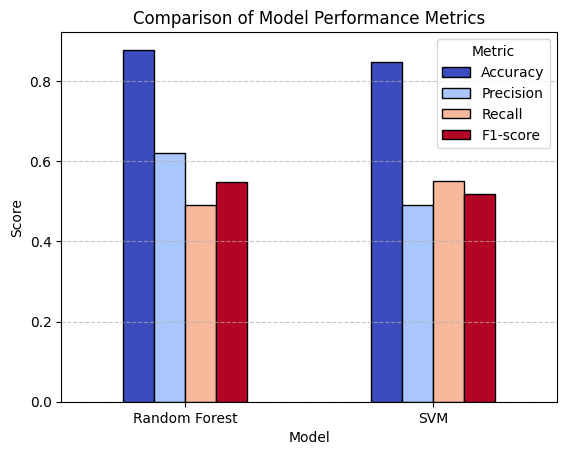

In [43]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Dizionario per salvare le metriche
metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

# Calcolo delle metriche per ogni modello
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    metrics["Model"].append(name)
    metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
    metrics["Precision"].append(precision_score(y_test, y_pred))
    metrics["Recall"].append(recall_score(y_test, y_pred))
    metrics["F1-score"].append(f1_score(y_test, y_pred))

# Creazione del DataFrame per la visualizzazione
metrics_df = pd.DataFrame(metrics)
metrics_df.set_index("Model", inplace=True)

# Creazione dell'istogramma
plt.figure(figsize=(10, 6))
metrics_df.plot(kind='bar', colormap='coolwarm', edgecolor='black')
plt.title("Comparison of Model Performance Metrics")
plt.ylabel("Score")
plt.xticks(rotation=0)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Random Forest maintains a more balanced performance across all metrics, making it the more reliable choice for maximizing campaign effectiveness.

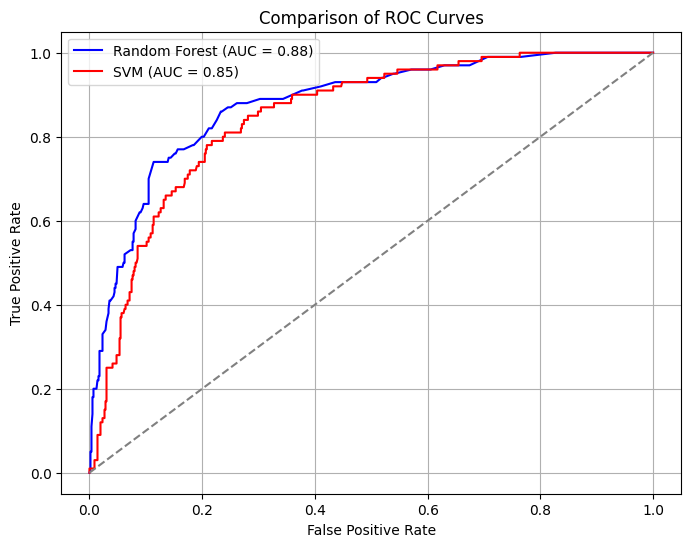


 Importance of Variables - Random Forest:
                     Feature  Importance
7   Accepted_Campaigns_Count    0.141740
9         Last_Purchase_Days    0.089277
6         Monthly_Web_Visits    0.078754
5          Catalog_Purchases    0.065440
4         In_Store_Purchases    0.063996
17          Spending_on_Gold    0.062165
2          Total_Expenditure    0.061384
12          Spending_on_Wine    0.050982
1              Annual_Income    0.050636
3           Online_Purchases    0.049897
10    Marital_Status_Encoded    0.048392
14          Spending_on_Meat    0.045216
13        Spending_on_Fruits    0.039577
16        Spending_on_Sweets    0.035241
8         Number_of_Children    0.035101
15          Spending_on_Fish    0.033671
0               Customer_Age    0.033643
11   Education_Level_Encoded    0.014887


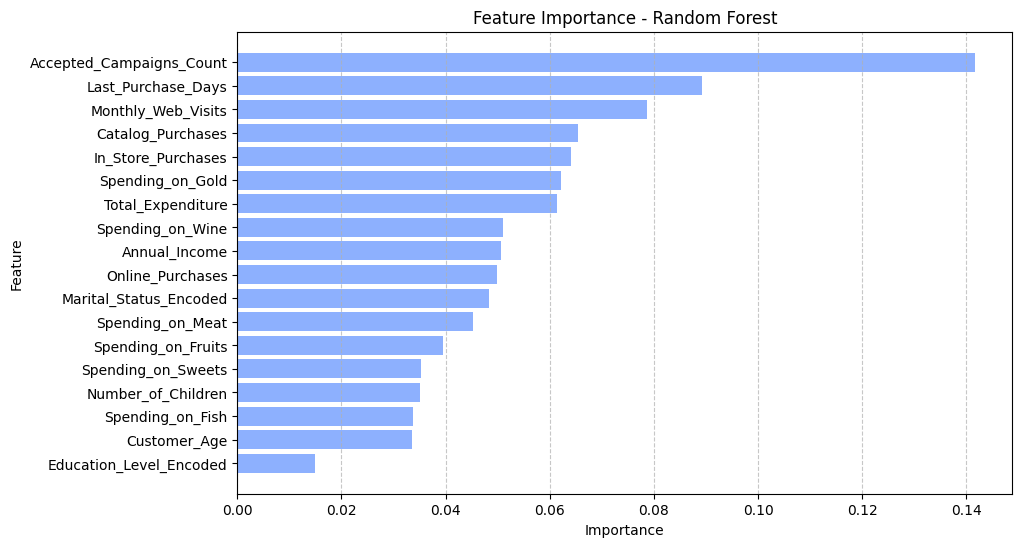

In [44]:
# Comparing models using the ROC curve
# Predictions for Random Forest
y_pred_rf = best_models["Random Forest"].predict(X_test)
y_proba_rf = best_models["Random Forest"].predict_proba(X_test)[:, 1]

# Predictions for Logistic Regression (or any other model you want to compare)
y_pred_logreg = best_models["SVM"].predict(X_test)
y_proba_logreg = best_models["SVM"].predict_proba(X_test)[:, 1]

# Compute ROC curve for both models
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
fpr_logreg, tpr_logreg, _ = roc_curve(y_test, y_proba_logreg)

# Compute AUC for both models
auc_rf = auc(fpr_rf, tpr_rf)
auc_logreg = auc(fpr_logreg, tpr_logreg)

# Plot ROC curve comparison
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.2f})", color='blue')
plt.plot(fpr_logreg, tpr_logreg, label=f"SVM (AUC = {auc_logreg:.2f})", color='red')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Comparison of ROC Curves")
plt.legend()
plt.grid()
plt.show()


# Analyzing important variables for Random Forest
feature_importance = pd.DataFrame({"Feature": X.columns, "Importance": best_models["Random Forest"].feature_importances_})
feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

# Displaying the most influential variables
print("\n Importance of Variables - Random Forest:")
print(feature_importance)

# Visualizing the most important variables as a bar chart
plt.figure(figsize=(10, 6))
plt.barh(feature_importance["Feature"], feature_importance["Importance"], color=couleur)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Random Forest")
plt.gca().invert_yaxis()  # Invert so the most important variable is at the top
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

Random Forest slightly outperformed SVM, achieving a higher AUC of 0.88 compared to 0.85.  
This indicates that Random Forest was better at distinguishing between customers likely to buy and those who were not.  
The Random Forest model highlights that the most influential variables in purchasing behavior are the number of accepted campaigns, recency, and monthly web visits, followed by catalog and store purchases.  
Variables like income, age, and education have a lower impact.

# PART 4
## Compare the two models with the use of the profit curve and answer the following question: what is the best percentage of customers to be contacted to maximize profits?


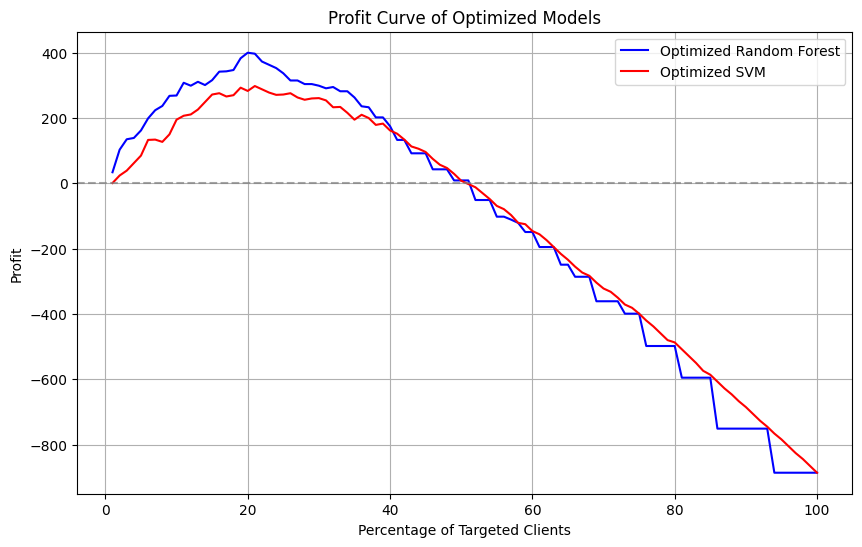

Best percentage of customers to contact (Random Forest): 20%
Best percentage of customers to contact (SVM): 21%


In [45]:
# Define financial parameters
cost_per_contact = 3  # Cost per contact
revenue_per_positive_response = 11  # Revenue generated from a positive response

# Function to calculate the profit based on the percentage of targeted clients
def calculate_profit(y_true, y_proba, threshold, cost_per_contact, revenue_per_positive_response):
    # Predictions based on the threshold
    y_pred = (y_proba >= threshold).astype(int)
    # Number of targeted clients
    total_contacts = y_pred.sum()
    # True positives (correctly predicted positive responses)
    true_positives = ((y_pred == 1) & (y_true == 1)).sum()
    # Profit calculation
    profit = (true_positives * revenue_per_positive_response) - (total_contacts * cost_per_contact)
    return profit

# Calculate profit for different thresholds and percentages of targeted clients
percentages = range(1, 101)  # From 1% to 100% of clients
profits_rf = []
profits_logreg = []

for percentage in percentages:
    threshold_rf = np.percentile(y_proba_rf, 100 - percentage)
    threshold_logreg = np.percentile(y_proba_logreg, 100 - percentage)
    
    profit_rf = calculate_profit(y_test, y_proba_rf, threshold_rf, cost_per_contact, revenue_per_positive_response)
    profit_logreg = calculate_profit(y_test, y_proba_logreg, threshold_logreg, cost_per_contact, revenue_per_positive_response)
    
    profits_rf.append(profit_rf)
    profits_logreg.append(profit_logreg)

# Visualize the profit curve
plt.figure(figsize=(10, 6))
plt.plot(percentages, profits_rf, label="Optimized Random Forest", color="blue")
plt.plot(percentages, profits_logreg, label="Optimized SVM", color="red")
plt.axhline(0, linestyle="--", color="gray", alpha=0.7)
plt.xlabel("Percentage of Targeted Clients")
plt.ylabel("Profit")
plt.title("Profit Curve of Optimized Models")
plt.legend()
plt.grid()
plt.show()

# Determine the best percentage for maximum profit
best_percentage_rf = percentages[np.argmax(profits_rf)]
best_percentage_logreg = percentages[np.argmax(profits_logreg)]

print(f"Best percentage of customers to contact (Random Forest): {best_percentage_rf}%")
print(f"Best percentage of customers to contact (SVM): {best_percentage_logreg}%")

The best contact strategy involves targeting 20% of customers, as recommended by the Random Forest model, which maximizes campaign profit at 400 MU.  
While the SVM model suggests targeting 21% of customers for higher profits, returns start to diminish beyond this threshold due to increased costs from non-buyers.  
Therefore, focusing on the 20% with Random Forest offers the most profitable approach.